# Load thư viện

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tabulate import tabulate

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import SimpleRNN

from keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import pandas_datareader.data as web

# Chuẩn bị dữ liệu

In [2]:
stock_name = "VNM"

In [3]:
raw_data = web.DataReader(stock_name,data_source="yahoo",start="01/01/2005",end="01/01/2019").dropna()

In [4]:
raw_data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2361.000000,2361.000000,2361.000000,2361.000000,2.361000e+03,2361.000000
mean,19.192325,18.864125,19.041749,19.023935,2.589617e+05,16.706554
std,4.093307,3.978572,4.043910,4.033770,2.369351e+05,2.811671
min,12.630000,12.340000,12.580000,12.550000,0.000000e+00,11.930043
25%,15.860000,15.560000,15.680000,15.680000,1.107000e+05,14.311843
50%,18.570000,18.250000,18.430000,18.430000,1.857000e+05,16.286385
75%,21.450001,21.080000,21.280001,21.290001,3.227000e+05,18.809763
max,32.200001,31.549999,32.000000,32.070000,2.509500e+06,26.154686


(2361, 1)                 Close
Date                 
2009-08-14  26.020000
2009-08-17  25.230000
2009-08-18  25.750000
2009-08-19  26.129999
2009-08-20  26.969999


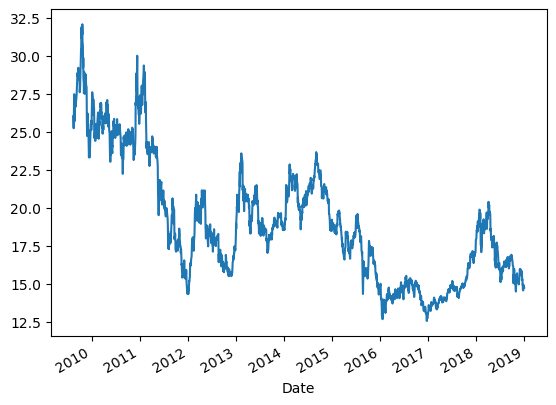

In [5]:
df = raw_data.dropna()
df = df[['Close']]
first_price = df.Close.iloc[0]
print(df.shape, df.head())

df.Close.plot()
def create_ds(ds, look_back):
    dataX, dataY = [], []
    for i in range(len(ds)-look_back-1): 
        data = ds[i:(i+look_back), 0]      
        dataX.append(data)
        dataY.append(ds[i + look_back, 0]) 
    return np.array(dataX), np.array(dataY)

ds = df.values
ds = ds.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
ds = scaler.fit_transform(ds)

In [6]:
#  Chia tập train và tập test theo ty lệ 0.85, 0.15
# train_size = int(len(ds) * 0.85)
# test_size = len(ds) - train_size
# train, test = ds[0:train_size,:], ds[train_size:len(ds)+1,:]

# outline

#### 1:
#### Đầu vào: train, test, look_back, opt, epochs, batch_size, validation_split
#### Đầu ra: Trained model
#### 2:
#### Đầu vào: 4 trained models
#### Đầu ra: 4 plots + bảng so sánh độ chính xác

# Xây dựng models

In [7]:
def create_train_test_data(train, test, look_back):
    trainX, trainY = create_ds(train, look_back)
    testX, testY = create_ds(test, look_back)

    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    return trainX, trainY, testX, testY

In [8]:
# trainX, trainY, testX, testY = create_train_test_data(train, test, look_back)

In [9]:
# hidden_nodes = math.sqrt(len(trainX) * 3) + 2 * math.sqrt(len(trainX) / 3)

## FFNN

In [10]:
def create_ffnn_model(trainX, trainY, look_back, opt, epochs, batch_size, validation_split):
    # create model
    hidden_nodes = int(math.sqrt(len(trainX) * 3) + 2 * math.sqrt(len(trainX) / 3))
    model_ffnn = Sequential()
    model_ffnn.add(Dense(hidden_nodes, input_shape = (trainX.shape[1],trainX.shape[2]), activation = 'relu', kernel_initializer='uniform'))
#     model_ffnn.add(Dropout(0.4))
#     model_ffnn.add(Dense(400, activation = 'relu', kernel_initializer='uniform' ))
#     model_ffnn.add(Dropout(0.3))
#     model_ffnn.add(Dense(150, activation = 'relu' ))
#     model_ffnn.add(Dropout(0.3))
#     model_ffnn.add(Dense(100, activation = 'hard_sigmoid' ))
#     model_ffnn.add(Dropout(0.2))
#     model_ffnn.add(Dense(50, activation = 'relu' ))
#     model_ffnn.add(Dropout(0.1))
#     model_ffnn.add(Dense(10, activation = 'relu' ))
    model_ffnn.add(Flatten())
    model_ffnn.add(Dense(1, activation = 'relu'))
    # train created model
    model_ffnn.compile(optimizer= opt, loss = "mean_squared_error")
    start = time.time()
    history = model_ffnn.fit(trainX, trainY, epochs = epochs , batch_size= batch_size, shuffle=True ,validation_split = validation_split)
    print('Thời gian huấn luyện: ', time.time() - start)
    model_ffnn.summary()
    delta = time.time() - start
    return delta, model_ffnn

## RNN

In [11]:
def create_rnn_model(trainX, trainY, look_back, opt, epochs, batch_size, validation_split):
    # create model
    hidden_nodes = int(math.sqrt(len(trainX) * 3) + 2 * math.sqrt(len(trainX) / 3))
    model_rnn = Sequential()
    model_rnn.add(SimpleRNN(units = hidden_nodes, activation = "tanh", return_sequences = True, input_shape = (look_back,1)))
#     model_rnn.add(Dropout(0.3))
#     model_rnn.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
#     model_rnn.add(Dropout(0.2))
#     model_rnn.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
#     model_rnn.add(Dropout(0.1))
#     model_rnn.add(SimpleRNN(units = 50))
    model_rnn.add(Flatten())
    model_rnn.add(Dense(units = 1))
    # train created model
    model_rnn.compile(optimizer= opt, loss = "mean_squared_error")
    start = time.time()
    history = model_rnn.fit(trainX, trainY, epochs = epochs , batch_size= batch_size, shuffle=True ,validation_split = validation_split)
    print('Thời gian huấn luyện: ', time.time() - start)
    model_rnn.summary()
    delta = time.time() - start
    return delta, model_rnn

## LSTM

In [12]:
def create_lstm_model(trainX, trainY, look_back, opt, epochs, batch_size, validation_split):
    # create model
    hidden_nodes = int(math.sqrt(len(trainX) * 3) + 2 * math.sqrt(len(trainX) / 3))
    model_lstm = Sequential()
    model_lstm.add(LSTM(hidden_nodes, activation = 'tanh', input_shape=(look_back,1),return_sequences=True))
    model_lstm.add(Flatten())
    model_lstm.add(Dense(1, activation = 'relu'))
    # train created model
    model_lstm.compile(optimizer= opt, loss = "mean_squared_error")
    start = time.time()
    history = model_lstm.fit(trainX, trainY, epochs = epochs , batch_size= batch_size, shuffle=True ,validation_split = validation_split)
    print('Thời gian huấn luyện: ', time.time() - start)
    model_lstm.summary()
    delta = time.time() - start
    return delta, model_lstm

## GRU

In [13]:
def create_gru_model(trainX, trainY, look_back, opt, epochs, batch_size, validation_split):
    # create model
    hidden_nodes = int(math.sqrt(len(trainX) * 3) + 2 * math.sqrt(len(trainX) / 3))
    model_gru = Sequential()
    model_gru.add(GRU(hidden_nodes, activation='tanh', recurrent_activation='sigmoid', input_shape=(look_back,1), return_sequences=True)) 
    model_gru.add(Flatten())
    model_gru.add(Dense(1, activation = 'relu'))
    # train created model
    model_gru.compile(optimizer= opt, loss = "mean_squared_error")
    start = time.time()
    history = model_gru.fit(trainX, trainY, epochs = epochs , batch_size= batch_size, shuffle=True ,validation_split = validation_split)
    print('Thời gian huấn luyện: ', time.time() - start)
    model_gru.summary()
    delta = time.time() - start
    return delta, model_gru

# Trực quan hóa, so sánh

In [14]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

def calculate_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return round(mse, 3), round(mae, 3), round(mape, 3), round(rmse, 3)

In [15]:
def create_accuracy(trained_model, scaler, trainX, trainY, testX, testY):
    trainPredict = trained_model.predict(trainX)
    testPredict = trained_model.predict(testX)

    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])

    mse, mae, mape, rmse = calculate_performance(trainY[0],trainPredict[:, 0])
    return mse, mae, mape, rmse, trainPredict, testPredict

In [16]:
def create_plot(ds, trainPredict, testPredict, scaler, look_back, model_name, stock_name):
    trainPredictPlot = np.empty_like(ds)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    testPredictPlot = np.empty_like(ds)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(ds)-1, :] = testPredict

    plt.style.use('ggplot')
    plt.figure(figsize=(13,7), dpi=110)
    plt.grid(color='grey', linestyle='dashed')
    plt.xlabel("{0} result".format(model_name))
    plt.ylabel('{0}'.format(stock_name),rotation=90)
    plt.plot(scaler.inverse_transform(ds), label = 'Actual Closing Prices', linewidth = 1.2, color = 'c')
    plt.plot(trainPredictPlot, label = 'A.I. Train Data Price Predictions_After fit', linewidth = 0.9, color = 'k')
    plt.plot(testPredictPlot, label = 'A.I. Test Data Price Predictions', linewidth = 0.9, color = 'r')
    legend = plt.legend(fontsize = 12,frameon = True)
    legend.get_frame().set_edgecolor('b')
    legend.get_frame().set_linewidth(0.4)

    plt.show()

# Thực nghiệm

In [17]:
look_back = 10
opt = Adam(learning_rate=0.0001)
import itertools
def get_combinations(parameters):
    return list(itertools.product(*parameters))

In [18]:
#dataset_ratio, epoch, batch_size, validation
information_FFNN_df = []
information_RNN_df = []
information_LSTM_df = []
information_GRU_df = []
params = [[0.6, 0.7, 0.8], [50, 100, 200], [32], [0.1, 0.15, 0.2]]
# params = [[0.8], [1, 2], [32], [0.15]]
params = get_combinations(params)
for p in params:
    ratio = p[0]
    train_size = int(len(ds) * ratio)
    test_size = len(ds) - train_size
    train, test = ds[0:train_size,:], ds[train_size:len(ds)+1,:]
    trainX, trainY, testX, testY = create_train_test_data(train, test, look_back)
    
    epochs = p[1]
    batch_size= p[2]
    validation_split= p[3]
    
    
    delta_ffnn, model_ffnn = create_ffnn_model(trainX, trainY, look_back, opt, epochs, batch_size, validation_split)
    delta_rnn, model_rnn = create_rnn_model(trainX, trainY, look_back, opt, epochs, batch_size, validation_split)
    delta_lstm, model_lstm = create_lstm_model(trainX, trainY, look_back, opt, epochs, batch_size, validation_split)
    delta_gru, model_gru =create_gru_model(trainX, trainY, look_back, opt, epochs, batch_size, validation_split)
    
    models_bag = {
        "FFNN": model_ffnn,
        "RNN": model_rnn,
        "LSTM": model_lstm,
        "GRU": model_gru
    }
    
    accuracy_bag = {}
    
    for model_name, trained_model in models_bag.items():
        if model_name == 'FFNN':
            mse, mae, mape, rmse, trainPredict, testPredict = create_accuracy(trained_model, scaler, trainX, trainY, testX, testY)
            info = [model_name] + list(p) + [mse, mae] + [delta_ffnn]
            information_FFNN_df.append(info)
        elif model_name == 'RNN':
            mse, mae, mape, rmse, trainPredict, testPredict = create_accuracy(trained_model, scaler, trainX, trainY, testX, testY)
            info = [model_name] + list(p) + [mse, mae] + [delta_rnn]
            information_RNN_df.append(info)
        elif model_name == 'LSTM':
            mse, mae, mape, rmse, trainPredict, testPredict = create_accuracy(trained_model, scaler, trainX, trainY, testX, testY)
            info = [model_name] + list(p) + [mse, mae] + [delta_lstm]
            information_LSTM_df.append(info)
        elif model_name == 'GRU':
            mse, mae, mape, rmse, trainPredict, testPredict = create_accuracy(trained_model, scaler, trainX, trainY, testX, testY)
            info = [model_name] + list(p) + [mse, mae] + [delta_gru]
            information_GRU_df.append(info)

Epoch 1/50
40/40 [==============================] - 1s 5ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 6/50
40/40 [==============================] - 0s 1ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 7/50
40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 8/50
40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 9/50
40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 10/50
40/40 [==============================] - 0s 1ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 11/50
40/40 [

40/40 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 5.2608e-04
Epoch 46/50
40/40 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 3.7098e-04
Epoch 47/50
40/40 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 4.8789e-04
Epoch 48/50
40/40 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 4.0891e-04
Epoch 49/50
40/40 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 4.8517e-04
Epoch 50/50
40/40 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 3.5563e-04
Thời gian huấn luyện:  16.401774644851685
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 108)           47520     
                                                                 
 flatten_2 (Flatten)         (None, 1080)              0         


Epoch 25/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 3.3190e-04
Epoch 26/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 3.4524e-04
Epoch 27/50
38/38 [==============================] - 0s 4ms/step - loss: 9.8258e-04 - val_loss: 2.8989e-04
Epoch 28/50
38/38 [==============================] - 0s 4ms/step - loss: 9.4979e-04 - val_loss: 2.7074e-04
Epoch 29/50
38/38 [==============================] - 0s 4ms/step - loss: 9.5697e-04 - val_loss: 2.7571e-04
Epoch 30/50
38/38 [==============================] - 0s 4ms/step - loss: 9.4095e-04 - val_loss: 2.6629e-04
Epoch 31/50
38/38 [==============================] - 0s 4ms/step - loss: 9.5029e-04 - val_loss: 2.9259e-04
Epoch 32/50
38/38 [==============================] - 0s 4ms/step - loss: 9.7319e-04 - val_loss: 2.8460e-04
Epoch 33/50
38/38 [==============================] - 0s 4ms/step - loss: 9.2012e-04 - val_loss: 3.3110e-04
Epoch 34/50
38/38 [==========================

Epoch 4/50
36/36 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0025
Epoch 5/50
36/36 [==============================] - 0s 3ms/step - loss: 0.0068 - val_loss: 0.0019
Epoch 6/50
36/36 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0017
Epoch 7/50
36/36 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0014
Epoch 8/50
36/36 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 9/50
36/36 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 10/50
36/36 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 9.4116e-04
Epoch 11/50
36/36 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 8.5785e-04
Epoch 12/50
36/36 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 8.5325e-04
Epoch 13/50
36/36 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 7.1510e-04


Epoch 26/50
36/36 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 4.4406e-04
Epoch 27/50
36/36 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 4.9107e-04
Epoch 28/50
36/36 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 4.0145e-04
Epoch 29/50
36/36 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 4.1545e-04
Epoch 30/50
36/36 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 3.6269e-04
Epoch 31/50
36/36 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 3.7381e-04
Epoch 32/50
36/36 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 3.9685e-04
Epoch 33/50
36/36 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 3.6885e-04
Epoch 34/50
36/36 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 3.3541e-04
Epoch 35/50
36/36 [==============================] - 0s 4ms/step - loss: 

Epoch 47/50
36/36 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 6.1782e-04
Epoch 48/50
36/36 [==============================] - 0s 9ms/step - loss: 0.0016 - val_loss: 5.5574e-04
Epoch 49/50
36/36 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 6.6366e-04
Epoch 50/50
36/36 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 5.3264e-04
Thời gian huấn luyện:  18.87940526008606
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 108)           47520     
                                                                 
 flatten_10 (Flatten)        (None, 1080)              0         
                                                                 
 dense_13 (Dense)            (None, 1)                 1081      
                                                             

Epoch 6/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0018
Epoch 7/100
40/40 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 8/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 9/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 10/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 8.1836e-04
Epoch 11/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 7.9029e-04
Epoch 12/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 7.1283e-04
Epoch 13/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 6.3940e-04
Epoch 14/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 6.3375e-04
Epoch 15/100
40/40 [==============================] - 0s 2ms/step - loss: 0.0016 - v

40/40 [==============================] - 0s 4ms/step - loss: 9.2518e-04 - val_loss: 2.4476e-04
Epoch 54/100
40/40 [==============================] - 0s 4ms/step - loss: 8.4676e-04 - val_loss: 3.1410e-04
Epoch 55/100
40/40 [==============================] - 0s 3ms/step - loss: 8.1184e-04 - val_loss: 3.5483e-04
Epoch 56/100
40/40 [==============================] - 0s 4ms/step - loss: 8.3129e-04 - val_loss: 5.0754e-04
Epoch 57/100
40/40 [==============================] - 0s 4ms/step - loss: 7.9765e-04 - val_loss: 2.3879e-04
Epoch 58/100
40/40 [==============================] - 0s 3ms/step - loss: 7.8933e-04 - val_loss: 2.5325e-04
Epoch 59/100
40/40 [==============================] - 0s 3ms/step - loss: 7.8683e-04 - val_loss: 2.3887e-04
Epoch 60/100
40/40 [==============================] - 0s 3ms/step - loss: 8.0291e-04 - val_loss: 2.9580e-04
Epoch 61/100
40/40 [==============================] - 0s 3ms/step - loss: 8.5304e-04 - val_loss: 4.1576e-04
Epoch 62/100
40/40 [=====================

Epoch 22/100
40/40 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 7.3968e-04
Epoch 23/100
40/40 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 5.7292e-04
Epoch 24/100
40/40 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 7.9068e-04
Epoch 25/100
40/40 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 6.1910e-04
Epoch 26/100
40/40 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 7.8494e-04
Epoch 27/100
40/40 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 6.3495e-04
Epoch 28/100
40/40 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 6.1880e-04
Epoch 29/100
40/40 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 5.7469e-04
Epoch 30/100
40/40 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 5.5584e-04
Epoch 31/100
40/40 [==============================] - 0s 8ms/ste

40/40 [==============================] - 0s 9ms/step - loss: 9.4786e-04 - val_loss: 2.9985e-04
Thời gian huấn luyện:  36.8007538318634
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 108)           47520     
                                                                 
 flatten_14 (Flatten)        (None, 1080)              0         
                                                                 
 dense_18 (Dense)            (None, 1)                 1081      
                                                                 
Total params: 48,601
Trainable params: 48,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
40/40 [==============================] - 3s 20ms/step - loss: 0.0263 - val_loss: 9.5701e-04
Epoch 2/100
40/40 [==============================] - 0s 9ms/step - loss: 0

38/38 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 4.8015e-04
Epoch 35/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 4.8031e-04
Epoch 36/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 4.7421e-04
Epoch 37/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 4.8669e-04
Epoch 38/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 4.6910e-04
Epoch 39/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 4.7105e-04
Epoch 40/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 4.6226e-04
Epoch 41/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 4.7973e-04
Epoch 42/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 4.9938e-04
Epoch 43/100
38/38 [==============================] - 0s 2ms/step - loss: 0.0

38/38 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 3.9383e-04
Epoch 5/100
38/38 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 5.1974e-04
Epoch 6/100
38/38 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 4.0191e-04
Epoch 7/100
38/38 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 2.9288e-04
Epoch 8/100
38/38 [==============================] - 0s 3ms/step - loss: 9.7321e-04 - val_loss: 5.1137e-04
Epoch 9/100
38/38 [==============================] - 0s 4ms/step - loss: 9.2780e-04 - val_loss: 2.7225e-04
Epoch 10/100
38/38 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 2.9956e-04
Epoch 11/100
38/38 [==============================] - 0s 3ms/step - loss: 8.9307e-04 - val_loss: 3.3630e-04
Epoch 12/100
38/38 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 2.6163e-04
Epoch 13/100
38/38 [==============================] - 0s 3ms/step - lo

Epoch 50/100
38/38 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 5.1507e-04
Epoch 51/100
38/38 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 5.4402e-04
Epoch 52/100
38/38 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 4.8637e-04
Epoch 53/100
38/38 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 4.8793e-04
Epoch 54/100
38/38 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 4.7546e-04
Epoch 55/100
38/38 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 4.6650e-04
Epoch 56/100
38/38 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 4.6159e-04
Epoch 57/100
38/38 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 5.1511e-04
Epoch 58/100
38/38 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 4.8816e-04
Epoch 59/100
38/38 [==============================] - 0s 9ms/s

38/38 [==============================] - 0s 8ms/step - loss: 7.1065e-04 - val_loss: 3.0739e-04
Epoch 97/100
38/38 [==============================] - 0s 8ms/step - loss: 6.9764e-04 - val_loss: 2.0657e-04
Epoch 98/100
38/38 [==============================] - 0s 8ms/step - loss: 6.9438e-04 - val_loss: 2.2661e-04
Epoch 99/100
38/38 [==============================] - 0s 8ms/step - loss: 6.8263e-04 - val_loss: 2.7626e-04
Epoch 100/100
38/38 [==============================] - 0s 8ms/step - loss: 6.9899e-04 - val_loss: 2.0960e-04
Thời gian huấn luyện:  35.79609775543213
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 10, 108)           35964     
                                                                 
 flatten_19 (Flatten)        (None, 1080)              0         
                                                                 
 dense_24 (D

Epoch 63/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 5.0442e-04
Epoch 64/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 4.5882e-04
Epoch 65/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 4.9877e-04
Epoch 66/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 4.5157e-04
Epoch 67/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 4.4837e-04
Epoch 68/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 5.1265e-04
Epoch 69/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 4.4772e-04
Epoch 70/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 4.6309e-04
Epoch 71/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 4.4518e-04
Epoch 72/100
36/36 [==============================] - 0s 2ms/ste

36/36 [==============================] - 3s 26ms/step - loss: 0.0473 - val_loss: 0.0023
Epoch 2/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0033 - val_loss: 9.3945e-04
Epoch 3/100
36/36 [==============================] - 0s 9ms/step - loss: 0.0026 - val_loss: 9.0470e-04
Epoch 4/100
36/36 [==============================] - 0s 9ms/step - loss: 0.0025 - val_loss: 8.7244e-04
Epoch 5/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 8.5155e-04
Epoch 6/100
36/36 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 8.4095e-04
Epoch 7/100
36/36 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 9.0336e-04
Epoch 8/100
36/36 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 8.4174e-04
Epoch 9/100
36/36 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 8.2200e-04
Epoch 10/100
36/36 [==============================] - 0s 9ms/step - loss: 0.0023 - val_l

Epoch 80/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0012 - val_loss: 5.3041e-04
Epoch 81/100
36/36 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 4.4906e-04
Epoch 82/100
36/36 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 4.0084e-04
Epoch 83/100
36/36 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 4.2346e-04
Epoch 84/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 4.0819e-04
Epoch 85/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 8.3585e-04
Epoch 86/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 4.9102e-04
Epoch 87/100
36/36 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 3.8767e-04
Epoch 88/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 4.5335e-04
Epoch 89/100
36/36 [==============================] - 0s 8ms/s

40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 16/200
40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 17/200
40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 18/200
40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 19/200
40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 20/200
40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 21/200
40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 22/200
40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 23/200
40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 24/200
40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 25/200


40/40 [==============================] - 0s 3ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 98/200
40/40 [==============================] - 0s 3ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 99/200
40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 100/200
40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 101/200
40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 102/200
40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 103/200
40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 104/200
40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 105/200
40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 106/200
40/40 [==============================] - 0s 2ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 

40/40 [==============================] - 0s 4ms/step - loss: 7.8326e-04 - val_loss: 3.5271e-04
Epoch 49/200
40/40 [==============================] - 0s 5ms/step - loss: 7.4223e-04 - val_loss: 2.6136e-04
Epoch 50/200
40/40 [==============================] - 0s 4ms/step - loss: 7.6350e-04 - val_loss: 2.8453e-04
Epoch 51/200
40/40 [==============================] - 0s 4ms/step - loss: 7.3598e-04 - val_loss: 2.0334e-04
Epoch 52/200
40/40 [==============================] - 0s 4ms/step - loss: 7.4555e-04 - val_loss: 4.4118e-04
Epoch 53/200
40/40 [==============================] - 0s 4ms/step - loss: 7.5795e-04 - val_loss: 2.1705e-04
Epoch 54/200
40/40 [==============================] - 0s 4ms/step - loss: 7.0804e-04 - val_loss: 2.4947e-04
Epoch 55/200
40/40 [==============================] - 0s 4ms/step - loss: 6.7892e-04 - val_loss: 2.2159e-04
Epoch 56/200
40/40 [==============================] - 0s 4ms/step - loss: 6.8750e-04 - val_loss: 2.2007e-04
Epoch 57/200
40/40 [=====================

Epoch 124/200
40/40 [==============================] - 0s 4ms/step - loss: 5.0800e-04 - val_loss: 1.9898e-04
Epoch 125/200
40/40 [==============================] - 0s 4ms/step - loss: 5.2404e-04 - val_loss: 2.6225e-04
Epoch 126/200
40/40 [==============================] - 0s 4ms/step - loss: 5.2092e-04 - val_loss: 1.7616e-04
Epoch 127/200
40/40 [==============================] - 0s 4ms/step - loss: 5.4234e-04 - val_loss: 1.5189e-04
Epoch 128/200
40/40 [==============================] - 0s 4ms/step - loss: 5.0213e-04 - val_loss: 4.7983e-04
Epoch 129/200
40/40 [==============================] - 0s 4ms/step - loss: 5.2842e-04 - val_loss: 1.9141e-04
Epoch 130/200
40/40 [==============================] - 0s 5ms/step - loss: 5.0904e-04 - val_loss: 1.5405e-04
Epoch 131/200
40/40 [==============================] - 0s 4ms/step - loss: 5.1936e-04 - val_loss: 3.1070e-04
Epoch 132/200
40/40 [==============================] - 0s 4ms/step - loss: 5.7609e-04 - val_loss: 1.7856e-04
Epoch 133/200
40/40

40/40 [==============================] - 0s 10ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 73/200
40/40 [==============================] - 0s 10ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 74/200
40/40 [==============================] - 0s 9ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 75/200
40/40 [==============================] - 0s 9ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 76/200
40/40 [==============================] - 0s 9ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 77/200
40/40 [==============================] - 0s 9ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 78/200
40/40 [==============================] - 0s 9ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 79/200
40/40 [==============================] - 0s 10ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 80/200
40/40 [==============================] - 0s 9ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 81/200
40/40 [==============================] - 0s 11ms/step - loss: 0.2390 - val_loss: 0.1529
Epoch 82/

40/40 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 5.0537e-04
Epoch 26/200
40/40 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 3.8470e-04
Epoch 27/200
40/40 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 4.4315e-04
Epoch 28/200
40/40 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 4.4454e-04
Epoch 29/200
40/40 [==============================] - 0s 10ms/step - loss: 0.0012 - val_loss: 4.4837e-04
Epoch 30/200
40/40 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 4.6784e-04
Epoch 31/200
40/40 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 4.8154e-04
Epoch 32/200
40/40 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 5.0835e-04
Epoch 33/200
40/40 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 4.4821e-04
Epoch 34/200
40/40 [==============================] - 0s 12ms/step - loss: 

Epoch 176/200
40/40 [==============================] - 0s 10ms/step - loss: 5.1043e-04 - val_loss: 1.6473e-04
Epoch 177/200
40/40 [==============================] - 0s 10ms/step - loss: 5.0390e-04 - val_loss: 1.5267e-04
Epoch 178/200
40/40 [==============================] - 0s 10ms/step - loss: 5.0608e-04 - val_loss: 2.0239e-04
Epoch 179/200
40/40 [==============================] - 0s 9ms/step - loss: 4.9504e-04 - val_loss: 1.5614e-04
Epoch 180/200
40/40 [==============================] - 0s 10ms/step - loss: 5.3239e-04 - val_loss: 1.7971e-04
Epoch 181/200
40/40 [==============================] - 0s 10ms/step - loss: 5.2811e-04 - val_loss: 1.6733e-04
Epoch 182/200
40/40 [==============================] - 0s 10ms/step - loss: 4.9829e-04 - val_loss: 2.0509e-04
Epoch 183/200
40/40 [==============================] - 0s 9ms/step - loss: 4.8971e-04 - val_loss: 1.7756e-04
Epoch 184/200
40/40 [==============================] - 0s 9ms/step - loss: 4.9428e-04 - val_loss: 1.5152e-04
Epoch 185/200

Epoch 43/200
38/38 [==============================] - 0s 3ms/step - loss: 0.2408 - val_loss: 0.1711
Epoch 44/200
38/38 [==============================] - 0s 3ms/step - loss: 0.2408 - val_loss: 0.1711
Epoch 45/200
38/38 [==============================] - 0s 2ms/step - loss: 0.2408 - val_loss: 0.1711
Epoch 46/200
38/38 [==============================] - 0s 2ms/step - loss: 0.2408 - val_loss: 0.1711
Epoch 47/200
38/38 [==============================] - 0s 2ms/step - loss: 0.2408 - val_loss: 0.1711
Epoch 48/200
38/38 [==============================] - 0s 2ms/step - loss: 0.2408 - val_loss: 0.1711
Epoch 49/200
38/38 [==============================] - 0s 2ms/step - loss: 0.2408 - val_loss: 0.1711
Epoch 50/200
38/38 [==============================] - 0s 2ms/step - loss: 0.2408 - val_loss: 0.1711
Epoch 51/200
38/38 [==============================] - 0s 2ms/step - loss: 0.2408 - val_loss: 0.1711
Epoch 52/200
38/38 [==============================] - 0s 2ms/step - loss: 0.2408 - val_loss: 0.1711


                                                                 
 dense_36 (Dense)            (None, 1)                 1081      
                                                                 
Total params: 1,297
Trainable params: 1,297
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
38/38 [==============================] - 1s 10ms/step - loss: 0.0621 - val_loss: 0.0038
Epoch 2/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 8.0451e-04
Epoch 3/200
38/38 [==============================] - 0s 5ms/step - loss: 0.0024 - val_loss: 9.0065e-04
Epoch 4/200
38/38 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 7.9003e-04
Epoch 5/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 7.6672e-04
Epoch 6/200
38/38 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 6.7235e-04
Epoch 7/200
38/38 [==============================] - 

Epoch 75/200
38/38 [==============================] - 0s 4ms/step - loss: 7.7109e-04 - val_loss: 2.5785e-04
Epoch 76/200
38/38 [==============================] - 0s 4ms/step - loss: 7.9617e-04 - val_loss: 2.2348e-04
Epoch 77/200
38/38 [==============================] - 0s 4ms/step - loss: 7.9588e-04 - val_loss: 2.2147e-04
Epoch 78/200
38/38 [==============================] - 0s 4ms/step - loss: 7.6650e-04 - val_loss: 2.2137e-04
Epoch 79/200
38/38 [==============================] - 0s 4ms/step - loss: 7.8358e-04 - val_loss: 2.3908e-04
Epoch 80/200
38/38 [==============================] - 0s 4ms/step - loss: 7.4803e-04 - val_loss: 2.7652e-04
Epoch 81/200
38/38 [==============================] - 0s 4ms/step - loss: 8.2703e-04 - val_loss: 3.4107e-04
Epoch 82/200
38/38 [==============================] - 0s 4ms/step - loss: 7.7857e-04 - val_loss: 3.8649e-04
Epoch 83/200
38/38 [==============================] - 0s 4ms/step - loss: 7.9669e-04 - val_loss: 2.4722e-04
Epoch 84/200
38/38 [========

38/38 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 7.4695e-04
Epoch 19/200
38/38 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 6.5952e-04
Epoch 20/200
38/38 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 6.5712e-04
Epoch 21/200
38/38 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 6.4888e-04
Epoch 22/200
38/38 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 6.3550e-04
Epoch 23/200
38/38 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 6.4811e-04
Epoch 24/200
38/38 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 6.4229e-04
Epoch 25/200
38/38 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 6.1577e-04
Epoch 26/200
38/38 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 6.0599e-04
Epoch 27/200
38/38 [==============================] - 0s 10ms/step - 

Epoch 171/200
38/38 [==============================] - 0s 10ms/step - loss: 7.8500e-04 - val_loss: 2.4503e-04
Epoch 172/200
38/38 [==============================] - 0s 10ms/step - loss: 7.7846e-04 - val_loss: 2.5618e-04
Epoch 173/200
38/38 [==============================] - 0s 9ms/step - loss: 7.7033e-04 - val_loss: 2.9401e-04
Epoch 174/200
38/38 [==============================] - 0s 10ms/step - loss: 7.9178e-04 - val_loss: 2.6119e-04
Epoch 175/200
38/38 [==============================] - 0s 9ms/step - loss: 7.6680e-04 - val_loss: 2.6609e-04
Epoch 176/200
38/38 [==============================] - 0s 10ms/step - loss: 8.0881e-04 - val_loss: 2.3807e-04
Epoch 177/200
38/38 [==============================] - 0s 11ms/step - loss: 7.9580e-04 - val_loss: 2.3557e-04
Epoch 178/200
38/38 [==============================] - 0s 10ms/step - loss: 7.8725e-04 - val_loss: 2.7395e-04
Epoch 179/200
38/38 [==============================] - 0s 10ms/step - loss: 7.7061e-04 - val_loss: 2.4414e-04
Epoch 180/20

Epoch 40/200
38/38 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 3.7003e-04
Epoch 41/200
38/38 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 3.6499e-04
Epoch 42/200
38/38 [==============================] - 0s 11ms/step - loss: 0.0010 - val_loss: 3.1838e-04
Epoch 43/200
38/38 [==============================] - 0s 9ms/step - loss: 0.0010 - val_loss: 3.2000e-04
Epoch 44/200
38/38 [==============================] - 0s 10ms/step - loss: 0.0010 - val_loss: 3.0697e-04
Epoch 45/200
38/38 [==============================] - 0s 9ms/step - loss: 0.0010 - val_loss: 3.3489e-04
Epoch 46/200
38/38 [==============================] - 0s 9ms/step - loss: 9.9076e-04 - val_loss: 2.9555e-04
Epoch 47/200
38/38 [==============================] - 0s 10ms/step - loss: 0.0010 - val_loss: 2.9322e-04
Epoch 48/200
38/38 [==============================] - 0s 9ms/step - loss: 0.0010 - val_loss: 3.8662e-04
Epoch 49/200
38/38 [==============================] - 0s 

Epoch 190/200
38/38 [==============================] - 0s 10ms/step - loss: 5.2468e-04 - val_loss: 1.5674e-04
Epoch 191/200
38/38 [==============================] - 0s 9ms/step - loss: 5.2030e-04 - val_loss: 1.6296e-04
Epoch 192/200
38/38 [==============================] - 0s 9ms/step - loss: 5.1213e-04 - val_loss: 1.6660e-04
Epoch 193/200
38/38 [==============================] - 0s 10ms/step - loss: 5.2481e-04 - val_loss: 1.5925e-04
Epoch 194/200
38/38 [==============================] - 0s 9ms/step - loss: 5.1742e-04 - val_loss: 1.5772e-04
Epoch 195/200
38/38 [==============================] - 0s 10ms/step - loss: 5.0916e-04 - val_loss: 1.6115e-04
Epoch 196/200
38/38 [==============================] - 0s 10ms/step - loss: 5.0475e-04 - val_loss: 1.6755e-04
Epoch 197/200
38/38 [==============================] - 0s 10ms/step - loss: 5.2327e-04 - val_loss: 1.5592e-04
Epoch 198/200
38/38 [==============================] - 0s 10ms/step - loss: 5.4039e-04 - val_loss: 1.6224e-04
Epoch 199/200

36/36 [==============================] - 0s 3ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 59/200
36/36 [==============================] - 0s 3ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 60/200
36/36 [==============================] - 0s 3ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 61/200
36/36 [==============================] - 0s 2ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 62/200
36/36 [==============================] - 0s 2ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 63/200
36/36 [==============================] - 0s 3ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 64/200
36/36 [==============================] - 0s 2ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 65/200
36/36 [==============================] - 0s 2ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 66/200
36/36 [==============================] - 0s 2ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 67/200
36/36 [==============================] - 0s 2ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 68/200


36/36 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 4.8894e-04
Epoch 12/200
36/36 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 4.9625e-04
Epoch 13/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 4.7176e-04
Epoch 14/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 4.9681e-04
Epoch 15/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 4.1653e-04
Epoch 16/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 4.1859e-04
Epoch 17/200
36/36 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 4.0170e-04
Epoch 18/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 3.9634e-04
Epoch 19/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 3.9935e-04
Epoch 20/200
36/36 [==============================] - 0s 4ms/step - loss: 0.0

Epoch 88/200
36/36 [==============================] - 0s 4ms/step - loss: 7.5284e-04 - val_loss: 2.4376e-04
Epoch 89/200
36/36 [==============================] - 0s 4ms/step - loss: 7.3088e-04 - val_loss: 2.3812e-04
Epoch 90/200
36/36 [==============================] - 0s 4ms/step - loss: 7.2247e-04 - val_loss: 4.2374e-04
Epoch 91/200
36/36 [==============================] - 0s 4ms/step - loss: 8.0950e-04 - val_loss: 2.4631e-04
Epoch 92/200
36/36 [==============================] - 0s 4ms/step - loss: 7.2619e-04 - val_loss: 2.7244e-04
Epoch 93/200
36/36 [==============================] - 0s 4ms/step - loss: 7.0801e-04 - val_loss: 2.3781e-04
Epoch 94/200
36/36 [==============================] - 0s 5ms/step - loss: 7.0451e-04 - val_loss: 2.3218e-04
Epoch 95/200
36/36 [==============================] - 0s 5ms/step - loss: 7.2198e-04 - val_loss: 2.3691e-04
Epoch 96/200
36/36 [==============================] - 0s 4ms/step - loss: 7.2032e-04 - val_loss: 2.4136e-04
Epoch 97/200
36/36 [========

Epoch 33/200
36/36 [==============================] - 0s 10ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 34/200
36/36 [==============================] - 0s 10ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 35/200
36/36 [==============================] - 0s 9ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 36/200
36/36 [==============================] - 0s 10ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 37/200
36/36 [==============================] - 0s 9ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 38/200
36/36 [==============================] - 0s 10ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 39/200
36/36 [==============================] - 0s 9ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 40/200
36/36 [==============================] - 0s 9ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 41/200
36/36 [==============================] - 0s 10ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 42/200
36/36 [==============================] - 0s 10ms/step - loss: 0.2440 - val_loss: 0

36/36 [==============================] - 0s 9ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 195/200
36/36 [==============================] - 0s 10ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 196/200
36/36 [==============================] - 0s 9ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 197/200
36/36 [==============================] - 0s 10ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 198/200
36/36 [==============================] - 0s 10ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 199/200
36/36 [==============================] - 0s 10ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 200/200
36/36 [==============================] - 0s 10ms/step - loss: 0.2440 - val_loss: 0.1756
Thời gian huấn luyện:  72.88359904289246
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10, 108)           47520     
                                        

36/36 [==============================] - 0s 8ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 149/200
36/36 [==============================] - 0s 8ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 150/200
36/36 [==============================] - 0s 8ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 151/200
36/36 [==============================] - 0s 8ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 152/200
36/36 [==============================] - 0s 8ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 153/200
36/36 [==============================] - 0s 8ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 154/200
36/36 [==============================] - 0s 8ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 155/200
36/36 [==============================] - 0s 8ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 156/200
36/36 [==============================] - 0s 9ms/step - loss: 0.2440 - val_loss: 0.1756
Epoch 157/200
36/36 [==============================] - 0s 8ms/step - loss: 0.2440 - val_loss: 0.1756
Epoc

Epoch 17/50
47/47 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 18/50
47/47 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 19/50
47/47 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 20/50
47/47 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 21/50
47/47 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 22/50
47/47 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 23/50
47/47 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 24/50
47/47 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 25/50
47/47 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 26/50
47/47 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 27/5

Epoch 39/50
47/47 [==============================] - 0s 3ms/step - loss: 7.5671e-04 - val_loss: 5.1119e-04
Epoch 40/50
47/47 [==============================] - 0s 4ms/step - loss: 7.1789e-04 - val_loss: 7.1171e-04
Epoch 41/50
47/47 [==============================] - 0s 4ms/step - loss: 7.9459e-04 - val_loss: 5.6281e-04
Epoch 42/50
47/47 [==============================] - 0s 4ms/step - loss: 7.2297e-04 - val_loss: 5.1608e-04
Epoch 43/50
47/47 [==============================] - 0s 4ms/step - loss: 7.0587e-04 - val_loss: 4.9551e-04
Epoch 44/50
47/47 [==============================] - 0s 4ms/step - loss: 7.1412e-04 - val_loss: 5.4841e-04
Epoch 45/50
47/47 [==============================] - 0s 4ms/step - loss: 6.8465e-04 - val_loss: 5.4974e-04
Epoch 46/50
47/47 [==============================] - 0s 4ms/step - loss: 6.8865e-04 - val_loss: 5.0141e-04
Epoch 47/50
47/47 [==============================] - 0s 4ms/step - loss: 6.8470e-04 - val_loss: 5.2294e-04
Epoch 48/50
47/47 [==================

Epoch 3/50
47/47 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 4/50
47/47 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 5/50
47/47 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 6/50
47/47 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 7/50
47/47 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 8/50
47/47 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 9/50
47/47 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 10/50
47/47 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 9.8238e-04
Epoch 11/50
47/47 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 12/50
47/47 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 13/50
4

44/44 [==============================] - 0s 4ms/step - loss: 8.5794e-04 - val_loss: 5.5206e-04
Epoch 42/50
44/44 [==============================] - 0s 4ms/step - loss: 8.5508e-04 - val_loss: 5.2360e-04
Epoch 43/50
44/44 [==============================] - 0s 4ms/step - loss: 8.3658e-04 - val_loss: 5.6009e-04
Epoch 44/50
44/44 [==============================] - 0s 4ms/step - loss: 8.2706e-04 - val_loss: 4.9878e-04
Epoch 45/50
44/44 [==============================] - 0s 4ms/step - loss: 8.5543e-04 - val_loss: 5.0440e-04
Epoch 46/50
44/44 [==============================] - 0s 5ms/step - loss: 8.1639e-04 - val_loss: 5.4314e-04
Epoch 47/50
44/44 [==============================] - 0s 5ms/step - loss: 8.9984e-04 - val_loss: 6.5087e-04
Epoch 48/50
44/44 [==============================] - 0s 4ms/step - loss: 8.1480e-04 - val_loss: 4.9577e-04
Epoch 49/50
44/44 [==============================] - 0s 4ms/step - loss: 7.9906e-04 - val_loss: 4.8022e-04
Epoch 50/50
44/44 [==============================

41/41 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 7.7298e-04
Epoch 23/50
41/41 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 7.7411e-04
Epoch 24/50
41/41 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 7.8197e-04
Epoch 25/50
41/41 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 7.8395e-04
Epoch 26/50
41/41 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 7.1828e-04
Epoch 27/50
41/41 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 7.8770e-04
Epoch 28/50
41/41 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 7.3729e-04
Epoch 29/50
41/41 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 7.0711e-04
Epoch 30/50
41/41 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 7.6615e-04
Epoch 31/50
41/41 [==============================] - 0s 2ms/step - loss: 0.0012 - val

41/41 [==============================] - 0s 10ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 6/50
41/41 [==============================] - 0s 9ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 7/50
41/41 [==============================] - 0s 9ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 8/50
41/41 [==============================] - 0s 9ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 9/50
41/41 [==============================] - 0s 8ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 10/50
41/41 [==============================] - 0s 9ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 11/50
41/41 [==============================] - 0s 9ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 12/50
41/41 [==============================] - 0s 8ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 13/50
41/41 [==============================] - 0s 8ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 14/50
41/41 [==============================] - 0s 8ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 15/50
41/41 [======

 dense_61 (Dense)            (None, 1)                 1161      
                                                                 
Total params: 1,393
Trainable params: 1,393
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
47/47 [==============================] - 2s 9ms/step - loss: 0.0138 - val_loss: 0.0015
Epoch 2/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 3/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 9.0081e-04
Epoch 4/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 9.4039e-04
Epoch 5/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 8.0122e-04
Epoch 6/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 8.5235e-04
Epoch 7/100
47/47 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 7.5431e-04
Epoch 8/100
47/47 [==

47/47 [==============================] - 0s 10ms/step - loss: 0.2228 - val_loss: 0.0352
Epoch 46/100
47/47 [==============================] - 0s 9ms/step - loss: 0.2228 - val_loss: 0.0352
Epoch 47/100
47/47 [==============================] - 0s 10ms/step - loss: 0.2228 - val_loss: 0.0352
Epoch 48/100
47/47 [==============================] - 0s 9ms/step - loss: 0.2228 - val_loss: 0.0352
Epoch 49/100
47/47 [==============================] - 0s 9ms/step - loss: 0.2228 - val_loss: 0.0352
Epoch 50/100
47/47 [==============================] - 0s 10ms/step - loss: 0.2228 - val_loss: 0.0352
Epoch 51/100
47/47 [==============================] - 0s 10ms/step - loss: 0.2228 - val_loss: 0.0352
Epoch 52/100
47/47 [==============================] - 0s 11ms/step - loss: 0.2228 - val_loss: 0.0352
Epoch 53/100
47/47 [==============================] - 0s 10ms/step - loss: 0.2228 - val_loss: 0.0352
Epoch 54/100
47/47 [==============================] - 0s 9ms/step - loss: 0.2228 - val_loss: 0.0352
Epoch 5

47/47 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 19/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 9.0549e-04
Epoch 20/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 9.2359e-04
Epoch 21/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 8.9056e-04
Epoch 22/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 8.8553e-04
Epoch 23/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 8.4500e-04
Epoch 24/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 8.1632e-04
Epoch 25/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 7.5514e-04
Epoch 26/100
47/47 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 8.0465e-04
Epoch 27/100
47/47 [==============================] - 0s 8ms/step - loss: 0.0011 

44/44 [==============================] - 0s 2ms/step - loss: 9.6361e-04 - val_loss: 6.2330e-04
Epoch 62/100
44/44 [==============================] - 0s 2ms/step - loss: 9.5543e-04 - val_loss: 7.3499e-04
Epoch 63/100
44/44 [==============================] - 0s 2ms/step - loss: 9.5268e-04 - val_loss: 6.4333e-04
Epoch 64/100
44/44 [==============================] - 0s 2ms/step - loss: 9.3066e-04 - val_loss: 6.1541e-04
Epoch 65/100
44/44 [==============================] - 0s 3ms/step - loss: 9.3029e-04 - val_loss: 6.5129e-04
Epoch 66/100
44/44 [==============================] - 0s 3ms/step - loss: 9.1050e-04 - val_loss: 6.4649e-04
Epoch 67/100
44/44 [==============================] - 0s 2ms/step - loss: 9.0196e-04 - val_loss: 6.3642e-04
Epoch 68/100
44/44 [==============================] - 0s 2ms/step - loss: 9.0595e-04 - val_loss: 5.9256e-04
Epoch 69/100
44/44 [==============================] - 0s 2ms/step - loss: 9.0135e-04 - val_loss: 6.1378e-04
Epoch 70/100
44/44 [=====================

Epoch 30/100
44/44 [==============================] - 0s 4ms/step - loss: 8.2724e-04 - val_loss: 4.8151e-04
Epoch 31/100
44/44 [==============================] - 0s 4ms/step - loss: 8.0882e-04 - val_loss: 6.0618e-04
Epoch 32/100
44/44 [==============================] - 0s 5ms/step - loss: 7.8431e-04 - val_loss: 5.3385e-04
Epoch 33/100
44/44 [==============================] - 0s 4ms/step - loss: 8.0789e-04 - val_loss: 4.8211e-04
Epoch 34/100
44/44 [==============================] - 0s 4ms/step - loss: 7.5067e-04 - val_loss: 4.9880e-04
Epoch 35/100
44/44 [==============================] - 0s 4ms/step - loss: 7.5137e-04 - val_loss: 4.5542e-04
Epoch 36/100
44/44 [==============================] - 0s 4ms/step - loss: 7.4615e-04 - val_loss: 4.5523e-04
Epoch 37/100
44/44 [==============================] - 0s 4ms/step - loss: 8.3316e-04 - val_loss: 4.4195e-04
Epoch 38/100
44/44 [==============================] - 0s 4ms/step - loss: 7.6439e-04 - val_loss: 4.3260e-04
Epoch 39/100
44/44 [========

 dense_67 (Dense)            (None, 1)                 1161      
                                                                 
Total params: 14,849
Trainable params: 14,849
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
44/44 [==============================] - 3s 19ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 2/100
44/44 [==============================] - 0s 9ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 3/100
44/44 [==============================] - 0s 9ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 4/100
44/44 [==============================] - 0s 10ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 5/100
44/44 [==============================] - 0s 10ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 6/100
44/44 [==============================] - 0s 10ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 7/100
44/44 [==============================] - 0s 9ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 8/100
44/44 [================

44/44 [==============================] - 0s 10ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 80/100
44/44 [==============================] - 0s 10ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 81/100
44/44 [==============================] - 0s 10ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 82/100
44/44 [==============================] - 0s 11ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 83/100
44/44 [==============================] - 0s 11ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 84/100
44/44 [==============================] - 0s 10ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 85/100
44/44 [==============================] - 0s 10ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 86/100
44/44 [==============================] - 0s 10ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 87/100
44/44 [==============================] - 0s 10ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 88/100
44/44 [==============================] - 0s 10ms/step - loss: 0.2316 - val_loss: 0.0475
Epo

44/44 [==============================] - 0s 8ms/step - loss: 8.5503e-04 - val_loss: 5.6041e-04
Epoch 51/100
44/44 [==============================] - 0s 9ms/step - loss: 8.5611e-04 - val_loss: 5.6249e-04
Epoch 52/100
44/44 [==============================] - 0s 8ms/step - loss: 8.4708e-04 - val_loss: 5.7626e-04
Epoch 53/100
44/44 [==============================] - 1s 15ms/step - loss: 8.3317e-04 - val_loss: 5.5326e-04
Epoch 54/100
44/44 [==============================] - 0s 10ms/step - loss: 8.2330e-04 - val_loss: 5.4486e-04
Epoch 55/100
44/44 [==============================] - 0s 10ms/step - loss: 8.2722e-04 - val_loss: 5.7293e-04
Epoch 56/100
44/44 [==============================] - 0s 8ms/step - loss: 8.1026e-04 - val_loss: 5.8369e-04
Epoch 57/100
44/44 [==============================] - 0s 9ms/step - loss: 8.1054e-04 - val_loss: 5.6424e-04
Epoch 58/100
44/44 [==============================] - 0s 9ms/step - loss: 8.0480e-04 - val_loss: 5.5646e-04
Epoch 59/100
44/44 [==================

41/41 [==============================] - 0s 2ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 16/100
41/41 [==============================] - 0s 2ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 17/100
41/41 [==============================] - 0s 2ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 18/100
41/41 [==============================] - 0s 2ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 19/100
41/41 [==============================] - 0s 2ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 20/100
41/41 [==============================] - 0s 2ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 21/100
41/41 [==============================] - 0s 2ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 22/100
41/41 [==============================] - 0s 3ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 23/100
41/41 [==============================] - 0s 2ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 24/100
41/41 [==============================] - 0s 2ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 25/100


41/41 [==============================] - 0s 3ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 98/100
41/41 [==============================] - 0s 2ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 99/100
41/41 [==============================] - 0s 2ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 100/100
41/41 [==============================] - 0s 2ms/step - loss: 0.2385 - val_loss: 0.0661
Thời gian huấn luyện:  9.544904470443726
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 10, 116)           232       
                                                                 
 flatten_56 (Flatten)        (None, 1160)              0         
                                                                 
 dense_71 (Dense)            (None, 1)                 1161      
                                                                 
Total params: 1,393


Epoch 66/100
41/41 [==============================] - 0s 5ms/step - loss: 6.0156e-04 - val_loss: 3.0780e-04
Epoch 67/100
41/41 [==============================] - 0s 4ms/step - loss: 5.9694e-04 - val_loss: 2.9334e-04
Epoch 68/100
41/41 [==============================] - 0s 4ms/step - loss: 5.9478e-04 - val_loss: 2.8667e-04
Epoch 69/100
41/41 [==============================] - 0s 4ms/step - loss: 6.0318e-04 - val_loss: 2.8513e-04
Epoch 70/100
41/41 [==============================] - 0s 4ms/step - loss: 5.9897e-04 - val_loss: 3.2470e-04
Epoch 71/100
41/41 [==============================] - 0s 4ms/step - loss: 6.0260e-04 - val_loss: 3.0179e-04
Epoch 72/100
41/41 [==============================] - 0s 4ms/step - loss: 6.0332e-04 - val_loss: 3.0371e-04
Epoch 73/100
41/41 [==============================] - 0s 4ms/step - loss: 5.8903e-04 - val_loss: 3.2681e-04
Epoch 74/100
41/41 [==============================] - 0s 4ms/step - loss: 5.9116e-04 - val_loss: 2.9654e-04
Epoch 75/100
41/41 [========

41/41 [==============================] - 0s 8ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 7/100
41/41 [==============================] - 0s 8ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 8/100
41/41 [==============================] - 0s 8ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 9/100
41/41 [==============================] - 0s 8ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 10/100
41/41 [==============================] - 0s 8ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 11/100
41/41 [==============================] - 0s 8ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 12/100
41/41 [==============================] - 0s 8ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 13/100
41/41 [==============================] - 0s 8ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 14/100
41/41 [==============================] - 0s 9ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 15/100
41/41 [==============================] - 0s 8ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 16/100
41/

41/41 [==============================] - 0s 8ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 89/100
41/41 [==============================] - 0s 8ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 90/100
41/41 [==============================] - 0s 8ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 91/100
41/41 [==============================] - 0s 8ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 92/100
41/41 [==============================] - 0s 8ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 93/100
41/41 [==============================] - 0s 9ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 94/100
41/41 [==============================] - 0s 8ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 95/100
41/41 [==============================] - 0s 8ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 96/100
41/41 [==============================] - 0s 8ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 97/100
41/41 [==============================] - 0s 8ms/step - loss: 0.2385 - val_loss: 0.0661
Epoch 98/100


Epoch 57/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 8.7486e-04
Epoch 58/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 8.7334e-04
Epoch 59/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 9.0027e-04
Epoch 60/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 9.2312e-04
Epoch 61/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 9.2212e-04
Epoch 62/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 9.1686e-04
Epoch 63/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 8.1193e-04
Epoch 64/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 8.8479e-04
Epoch 65/200
47/47 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 8.2568e-04
Epoch 66/200
47/47 [==============================] - 0s 2ms/ste

47/47 [==============================] - 0s 3ms/step - loss: 5.8567e-04 - val_loss: 4.6415e-04
Epoch 134/200
47/47 [==============================] - 0s 2ms/step - loss: 5.8427e-04 - val_loss: 4.4490e-04
Epoch 135/200
47/47 [==============================] - 0s 2ms/step - loss: 5.7641e-04 - val_loss: 4.9303e-04
Epoch 136/200
47/47 [==============================] - 0s 2ms/step - loss: 5.7676e-04 - val_loss: 4.3787e-04
Epoch 137/200
47/47 [==============================] - 0s 2ms/step - loss: 5.7254e-04 - val_loss: 4.4881e-04
Epoch 138/200
47/47 [==============================] - 0s 2ms/step - loss: 5.7123e-04 - val_loss: 4.7110e-04
Epoch 139/200
47/47 [==============================] - 0s 2ms/step - loss: 5.6654e-04 - val_loss: 4.5446e-04
Epoch 140/200
47/47 [==============================] - 0s 2ms/step - loss: 5.6630e-04 - val_loss: 4.5894e-04
Epoch 141/200
47/47 [==============================] - 0s 2ms/step - loss: 5.7099e-04 - val_loss: 4.7781e-04
Epoch 142/200
47/47 [============

Epoch 1/200
47/47 [==============================] - 1s 8ms/step - loss: 0.0156 - val_loss: 0.0020
Epoch 2/200
47/47 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 3/200
47/47 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 4/200
47/47 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 5/200
47/47 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 6/200
47/47 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 8.9329e-04
Epoch 7/200
47/47 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 7.8119e-04
Epoch 8/200
47/47 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 9.9021e-04
Epoch 9/200
47/47 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 7.3016e-04
Epoch 10/200
47/47 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 

47/47 [==============================] - 0s 4ms/step - loss: 4.3421e-04 - val_loss: 2.5128e-04
Epoch 153/200
47/47 [==============================] - 0s 4ms/step - loss: 4.2268e-04 - val_loss: 2.7248e-04
Epoch 154/200
47/47 [==============================] - 0s 4ms/step - loss: 4.2815e-04 - val_loss: 3.1406e-04
Epoch 155/200
47/47 [==============================] - 0s 3ms/step - loss: 4.5362e-04 - val_loss: 2.7721e-04
Epoch 156/200
47/47 [==============================] - 0s 3ms/step - loss: 4.3127e-04 - val_loss: 2.5997e-04
Epoch 157/200
47/47 [==============================] - 0s 3ms/step - loss: 4.1297e-04 - val_loss: 2.8019e-04
Epoch 158/200
47/47 [==============================] - 0s 3ms/step - loss: 4.2737e-04 - val_loss: 2.5179e-04
Epoch 159/200
47/47 [==============================] - 0s 4ms/step - loss: 4.0897e-04 - val_loss: 2.5761e-04
Epoch 160/200
47/47 [==============================] - 0s 4ms/step - loss: 4.8007e-04 - val_loss: 2.6510e-04
Epoch 161/200
47/47 [============

Epoch 21/200
47/47 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 22/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 23/200
47/47 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 24/200
47/47 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 25/200
47/47 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 26/200
47/47 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 27/200
47/47 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 28/200
47/47 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 29/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 30/200
47/47 [==============================] - 0s 10ms/step - loss: 0.0015 - val_los

Epoch 99/200
47/47 [==============================] - 0s 10ms/step - loss: 8.3952e-04 - val_loss: 6.5976e-04
Epoch 100/200
47/47 [==============================] - 0s 10ms/step - loss: 8.2076e-04 - val_loss: 6.5780e-04
Epoch 101/200
47/47 [==============================] - 0s 10ms/step - loss: 8.3794e-04 - val_loss: 6.1040e-04
Epoch 102/200
47/47 [==============================] - 1s 11ms/step - loss: 8.3836e-04 - val_loss: 7.2507e-04
Epoch 103/200
47/47 [==============================] - 0s 9ms/step - loss: 8.2911e-04 - val_loss: 6.9343e-04
Epoch 104/200
47/47 [==============================] - 0s 10ms/step - loss: 8.0864e-04 - val_loss: 6.1270e-04
Epoch 105/200
47/47 [==============================] - 0s 10ms/step - loss: 8.0436e-04 - val_loss: 6.9908e-04
Epoch 106/200
47/47 [==============================] - 0s 9ms/step - loss: 8.2428e-04 - val_loss: 6.5541e-04
Epoch 107/200
47/47 [==============================] - 0s 10ms/step - loss: 8.2944e-04 - val_loss: 7.8760e-04
Epoch 108/200

47/47 [==============================] - 0s 9ms/step - loss: 6.3073e-04 - val_loss: 5.0425e-04
Epoch 175/200
47/47 [==============================] - 0s 9ms/step - loss: 6.1320e-04 - val_loss: 5.7394e-04
Epoch 176/200
47/47 [==============================] - 0s 9ms/step - loss: 6.2613e-04 - val_loss: 5.3793e-04
Epoch 177/200
47/47 [==============================] - 0s 9ms/step - loss: 6.2027e-04 - val_loss: 5.7634e-04
Epoch 178/200
47/47 [==============================] - 0s 9ms/step - loss: 6.0121e-04 - val_loss: 5.0159e-04
Epoch 179/200
47/47 [==============================] - 0s 10ms/step - loss: 6.0578e-04 - val_loss: 4.7182e-04
Epoch 180/200
47/47 [==============================] - 0s 9ms/step - loss: 6.1832e-04 - val_loss: 5.3941e-04
Epoch 181/200
47/47 [==============================] - 0s 9ms/step - loss: 6.2528e-04 - val_loss: 5.7732e-04
Epoch 182/200
47/47 [==============================] - 0s 9ms/step - loss: 6.0687e-04 - val_loss: 5.3110e-04
Epoch 183/200
47/47 [===========

47/47 [==============================] - 0s 8ms/step - loss: 5.4163e-04 - val_loss: 3.9760e-04
Epoch 119/200
47/47 [==============================] - 0s 8ms/step - loss: 5.3270e-04 - val_loss: 4.0887e-04
Epoch 120/200
47/47 [==============================] - 0s 8ms/step - loss: 5.2143e-04 - val_loss: 3.9420e-04
Epoch 121/200
47/47 [==============================] - 0s 8ms/step - loss: 5.2030e-04 - val_loss: 4.2830e-04
Epoch 122/200
47/47 [==============================] - 0s 8ms/step - loss: 5.2873e-04 - val_loss: 3.7668e-04
Epoch 123/200
47/47 [==============================] - 0s 8ms/step - loss: 5.2150e-04 - val_loss: 4.1926e-04
Epoch 124/200
47/47 [==============================] - 0s 8ms/step - loss: 5.1624e-04 - val_loss: 4.0887e-04
Epoch 125/200
47/47 [==============================] - 0s 10ms/step - loss: 5.1219e-04 - val_loss: 4.0766e-04
Epoch 126/200
47/47 [==============================] - 0s 8ms/step - loss: 5.1958e-04 - val_loss: 4.1799e-04
Epoch 127/200
47/47 [===========

44/44 [==============================] - 0s 2ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 62/200
44/44 [==============================] - 0s 2ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 63/200
44/44 [==============================] - 0s 3ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 64/200
44/44 [==============================] - 0s 2ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 65/200
44/44 [==============================] - 0s 2ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 66/200
44/44 [==============================] - 0s 2ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 67/200
44/44 [==============================] - 0s 2ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 68/200
44/44 [==============================] - 0s 2ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 69/200
44/44 [==============================] - 0s 2ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 70/200
44/44 [==============================] - 0s 2ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 71/200


44/44 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 7.6698e-04
Epoch 15/200
44/44 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 7.4397e-04
Epoch 16/200
44/44 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 7.0682e-04
Epoch 17/200
44/44 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 7.8908e-04
Epoch 18/200
44/44 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 6.7060e-04
Epoch 19/200
44/44 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 6.8888e-04
Epoch 20/200
44/44 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 7.0825e-04
Epoch 21/200
44/44 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 6.7824e-04
Epoch 22/200
44/44 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 6.9774e-04
Epoch 23/200
44/44 [==============================] - 0s 4ms/step - loss: 0.0

44/44 [==============================] - 0s 4ms/step - loss: 4.2767e-04 - val_loss: 2.2330e-04
Epoch 166/200
44/44 [==============================] - 0s 4ms/step - loss: 4.2763e-04 - val_loss: 2.5123e-04
Epoch 167/200
44/44 [==============================] - 0s 4ms/step - loss: 4.2963e-04 - val_loss: 2.3732e-04
Epoch 168/200
44/44 [==============================] - 0s 4ms/step - loss: 4.2316e-04 - val_loss: 2.2219e-04
Epoch 169/200
44/44 [==============================] - 0s 4ms/step - loss: 4.3445e-04 - val_loss: 2.4432e-04
Epoch 170/200
44/44 [==============================] - 0s 4ms/step - loss: 4.4959e-04 - val_loss: 2.4274e-04
Epoch 171/200
44/44 [==============================] - 0s 4ms/step - loss: 4.3360e-04 - val_loss: 2.2050e-04
Epoch 172/200
44/44 [==============================] - 0s 5ms/step - loss: 4.2342e-04 - val_loss: 2.1853e-04
Epoch 173/200
44/44 [==============================] - 0s 4ms/step - loss: 4.3499e-04 - val_loss: 2.1718e-04
Epoch 174/200
44/44 [============

44/44 [==============================] - 0s 9ms/step - loss: 9.2264e-04 - val_loss: 6.1377e-04
Epoch 113/200
44/44 [==============================] - 0s 9ms/step - loss: 8.9277e-04 - val_loss: 6.3856e-04
Epoch 114/200
44/44 [==============================] - 0s 9ms/step - loss: 8.4183e-04 - val_loss: 5.7330e-04
Epoch 115/200
44/44 [==============================] - 0s 9ms/step - loss: 8.2681e-04 - val_loss: 5.6795e-04
Epoch 116/200
44/44 [==============================] - 0s 11ms/step - loss: 8.5342e-04 - val_loss: 6.2813e-04
Epoch 117/200
44/44 [==============================] - 0s 9ms/step - loss: 8.5702e-04 - val_loss: 6.0607e-04
Epoch 118/200
44/44 [==============================] - 0s 9ms/step - loss: 8.1118e-04 - val_loss: 5.9750e-04
Epoch 119/200
44/44 [==============================] - 0s 9ms/step - loss: 8.2772e-04 - val_loss: 6.0204e-04
Epoch 120/200
44/44 [==============================] - 0s 9ms/step - loss: 8.1383e-04 - val_loss: 5.4163e-04
Epoch 121/200
44/44 [===========

44/44 [==============================] - 0s 9ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 60/200
44/44 [==============================] - 0s 9ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 61/200
44/44 [==============================] - 0s 9ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 62/200
44/44 [==============================] - 0s 9ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 63/200
44/44 [==============================] - 0s 8ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 64/200
44/44 [==============================] - 0s 9ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 65/200
44/44 [==============================] - 0s 8ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 66/200
44/44 [==============================] - 0s 8ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 67/200
44/44 [==============================] - 0s 9ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 68/200
44/44 [==============================] - 0s 9ms/step - loss: 0.2316 - val_loss: 0.0475
Epoch 69/200


41/41 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 9/200
41/41 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 10/200
41/41 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 11/200
41/41 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 12/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 13/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 14/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 15/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 9.9869e-04
Epoch 16/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 9.8049e-04
Epoch 17/200
41/41 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 8.8621e-04
Ep

41/41 [==============================] - 0s 2ms/step - loss: 5.4592e-04 - val_loss: 3.3759e-04
Epoch 162/200
41/41 [==============================] - 0s 2ms/step - loss: 5.4170e-04 - val_loss: 3.4220e-04
Epoch 163/200
41/41 [==============================] - 0s 3ms/step - loss: 5.4308e-04 - val_loss: 3.0336e-04
Epoch 164/200
41/41 [==============================] - 0s 2ms/step - loss: 5.4146e-04 - val_loss: 3.0185e-04
Epoch 165/200
41/41 [==============================] - 0s 2ms/step - loss: 5.3626e-04 - val_loss: 2.9406e-04
Epoch 166/200
41/41 [==============================] - 0s 2ms/step - loss: 5.3611e-04 - val_loss: 2.9443e-04
Epoch 167/200
41/41 [==============================] - 0s 2ms/step - loss: 5.3576e-04 - val_loss: 3.3068e-04
Epoch 168/200
41/41 [==============================] - 0s 2ms/step - loss: 5.3336e-04 - val_loss: 2.7364e-04
Epoch 169/200
41/41 [==============================] - 0s 2ms/step - loss: 5.2993e-04 - val_loss: 2.8730e-04
Epoch 170/200
41/41 [============

41/41 [==============================] - 0s 4ms/step - loss: 7.0285e-04 - val_loss: 3.7286e-04
Epoch 30/200
41/41 [==============================] - 0s 4ms/step - loss: 6.7735e-04 - val_loss: 3.3852e-04
Epoch 31/200
41/41 [==============================] - 0s 4ms/step - loss: 7.0813e-04 - val_loss: 3.2884e-04
Epoch 32/200
41/41 [==============================] - 0s 4ms/step - loss: 7.0472e-04 - val_loss: 3.3011e-04
Epoch 33/200
41/41 [==============================] - 0s 4ms/step - loss: 6.7400e-04 - val_loss: 3.4414e-04
Epoch 34/200
41/41 [==============================] - 0s 4ms/step - loss: 6.5328e-04 - val_loss: 3.2719e-04
Epoch 35/200
41/41 [==============================] - 0s 4ms/step - loss: 7.0160e-04 - val_loss: 3.2007e-04
Epoch 36/200
41/41 [==============================] - 0s 4ms/step - loss: 6.5501e-04 - val_loss: 3.2599e-04
Epoch 37/200
41/41 [==============================] - 0s 4ms/step - loss: 6.4828e-04 - val_loss: 3.4557e-04
Epoch 38/200
41/41 [=====================

Epoch 105/200
41/41 [==============================] - 0s 4ms/step - loss: 5.0196e-04 - val_loss: 2.2596e-04
Epoch 106/200
41/41 [==============================] - 0s 4ms/step - loss: 5.0726e-04 - val_loss: 2.3642e-04
Epoch 107/200
41/41 [==============================] - 0s 4ms/step - loss: 5.0410e-04 - val_loss: 2.2458e-04
Epoch 108/200
41/41 [==============================] - 0s 4ms/step - loss: 4.9779e-04 - val_loss: 2.3448e-04
Epoch 109/200
41/41 [==============================] - 0s 4ms/step - loss: 4.8130e-04 - val_loss: 2.3149e-04
Epoch 110/200
41/41 [==============================] - 0s 4ms/step - loss: 4.9980e-04 - val_loss: 2.2274e-04
Epoch 111/200
41/41 [==============================] - 0s 4ms/step - loss: 4.7932e-04 - val_loss: 2.3380e-04
Epoch 112/200
41/41 [==============================] - 0s 4ms/step - loss: 4.8667e-04 - val_loss: 2.2559e-04
Epoch 113/200
41/41 [==============================] - 0s 4ms/step - loss: 5.5380e-04 - val_loss: 2.2306e-04
Epoch 114/200
41/41

41/41 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 6.5809e-04
Epoch 51/200
41/41 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 7.4601e-04
Epoch 52/200
41/41 [==============================] - 0s 10ms/step - loss: 0.0012 - val_loss: 6.2161e-04
Epoch 53/200
41/41 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 6.3145e-04
Epoch 54/200
41/41 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 6.7046e-04
Epoch 55/200
41/41 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 6.4028e-04
Epoch 56/200
41/41 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 5.8165e-04
Epoch 57/200
41/41 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 7.4392e-04
Epoch 58/200
41/41 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 6.3065e-04
Epoch 59/200
41/41 [==============================] - 0s 9ms/step - loss: 0.

Epoch 127/200
41/41 [==============================] - 0s 9ms/step - loss: 8.1590e-04 - val_loss: 4.7181e-04
Epoch 128/200
41/41 [==============================] - 0s 9ms/step - loss: 8.1453e-04 - val_loss: 4.7263e-04
Epoch 129/200
41/41 [==============================] - 0s 9ms/step - loss: 8.1118e-04 - val_loss: 5.3450e-04
Epoch 130/200
41/41 [==============================] - 0s 9ms/step - loss: 8.0912e-04 - val_loss: 4.6522e-04
Epoch 131/200
41/41 [==============================] - 0s 10ms/step - loss: 8.0474e-04 - val_loss: 4.5917e-04
Epoch 132/200
41/41 [==============================] - 0s 9ms/step - loss: 8.0439e-04 - val_loss: 4.6096e-04
Epoch 133/200
41/41 [==============================] - 0s 9ms/step - loss: 8.1136e-04 - val_loss: 4.6284e-04
Epoch 134/200
41/41 [==============================] - 0s 9ms/step - loss: 8.1152e-04 - val_loss: 4.5262e-04
Epoch 135/200
41/41 [==============================] - 0s 8ms/step - loss: 8.0599e-04 - val_loss: 4.6879e-04
Epoch 136/200
41/4

 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 10, 116)           54752     
                                                                 
 flatten_70 (Flatten)        (None, 1160)              0         
                                                                 
 dense_88 (Dense)            (None, 1)                 1161      
                                                                 
Total params: 55,913
Trainable params: 55,913
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
41/41 [==============================] - 2s 18ms/step - loss: 0.0294 - val_loss: 0.0015
Epoch 2/200
41/41 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 3/200
41/41 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 4/200
41/41 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch

41/41 [==============================] - 0s 9ms/step - loss: 5.3141e-04 - val_loss: 2.8968e-04
Epoch 147/200
41/41 [==============================] - 0s 8ms/step - loss: 5.3580e-04 - val_loss: 2.9022e-04
Epoch 148/200
41/41 [==============================] - 0s 9ms/step - loss: 5.2280e-04 - val_loss: 2.7857e-04
Epoch 149/200
41/41 [==============================] - 0s 10ms/step - loss: 5.1895e-04 - val_loss: 2.9327e-04
Epoch 150/200
41/41 [==============================] - 0s 9ms/step - loss: 5.3068e-04 - val_loss: 2.9639e-04
Epoch 151/200
41/41 [==============================] - 0s 8ms/step - loss: 5.1968e-04 - val_loss: 2.7287e-04
Epoch 152/200
41/41 [==============================] - 0s 8ms/step - loss: 5.2520e-04 - val_loss: 2.7036e-04
Epoch 153/200
41/41 [==============================] - 0s 8ms/step - loss: 5.0621e-04 - val_loss: 2.6810e-04
Epoch 154/200
41/41 [==============================] - 0s 9ms/step - loss: 5.1604e-04 - val_loss: 2.9925e-04
Epoch 155/200
41/41 [===========

53/53 [==============================] - 0s 4ms/step - loss: 7.8609e-04 - val_loss: 1.5941e-04
Epoch 31/50
53/53 [==============================] - 0s 4ms/step - loss: 7.4908e-04 - val_loss: 1.5550e-04
Epoch 32/50
53/53 [==============================] - 0s 4ms/step - loss: 7.4689e-04 - val_loss: 1.5425e-04
Epoch 33/50
53/53 [==============================] - 0s 5ms/step - loss: 7.3704e-04 - val_loss: 1.5458e-04
Epoch 34/50
53/53 [==============================] - 0s 5ms/step - loss: 7.4015e-04 - val_loss: 1.6358e-04
Epoch 35/50
53/53 [==============================] - 0s 4ms/step - loss: 7.4052e-04 - val_loss: 1.5042e-04
Epoch 36/50
53/53 [==============================] - 0s 4ms/step - loss: 7.3565e-04 - val_loss: 1.4899e-04
Epoch 37/50
53/53 [==============================] - 0s 4ms/step - loss: 7.2033e-04 - val_loss: 1.5963e-04
Epoch 38/50
53/53 [==============================] - 0s 5ms/step - loss: 7.0445e-04 - val_loss: 1.5439e-04
Epoch 39/50
53/53 [==============================

 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 10, 125)           63500     
                                                                 
 flatten_74 (Flatten)        (None, 1250)              0         
                                                                 
 dense_93 (Dense)            (None, 1)                 1251      
                                                                 
Total params: 64,751
Trainable params: 64,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
53/53 [==============================] - 3s 18ms/step - loss: 0.1983 - val_loss: 0.0094
Epoch 2/50
53/53 [==============================] - 0s 9ms/step - loss: 0.1983 - val_loss: 0.0094
Epoch 3/50
53/53 [==============================] - 0s 9ms/step - loss: 0.1983 - val_loss: 0.0094
Epoch 4/50
53/53 [==============================] - 0s 9ms/step - loss: 0.1983 - val_loss: 0.0094
Epoch 5/5

50/50 [==============================] - 0s 4ms/step - loss: 7.5744e-04 - val_loss: 2.1501e-04
Epoch 36/50
50/50 [==============================] - 0s 4ms/step - loss: 7.4811e-04 - val_loss: 2.2021e-04
Epoch 37/50
50/50 [==============================] - 0s 4ms/step - loss: 7.4061e-04 - val_loss: 2.2727e-04
Epoch 38/50
50/50 [==============================] - 0s 4ms/step - loss: 7.4398e-04 - val_loss: 2.3215e-04
Epoch 39/50
50/50 [==============================] - 0s 4ms/step - loss: 7.8476e-04 - val_loss: 2.4731e-04
Epoch 40/50
50/50 [==============================] - 0s 4ms/step - loss: 7.5842e-04 - val_loss: 2.0061e-04
Epoch 41/50
50/50 [==============================] - 0s 4ms/step - loss: 7.2301e-04 - val_loss: 1.8303e-04
Epoch 42/50
50/50 [==============================] - 0s 5ms/step - loss: 7.1212e-04 - val_loss: 2.1932e-04
Epoch 43/50
50/50 [==============================] - 0s 4ms/step - loss: 7.0265e-04 - val_loss: 1.8643e-04
Epoch 44/50
50/50 [==============================

Total params: 64,751
Trainable params: 64,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
50/50 [==============================] - 3s 16ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 2/50
50/50 [==============================] - 0s 9ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 3/50
50/50 [==============================] - 0s 9ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 4/50
50/50 [==============================] - 0s 8ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 5/50
50/50 [==============================] - 0s 8ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 6/50
50/50 [==============================] - 0s 8ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 7/50
50/50 [==============================] - 0s 8ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 8/50
50/50 [==============================] - 0s 9ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 9/50
50/50 [==============================] - 0s 9ms/step - loss: 0.2097 

Epoch 19/50
47/47 [==============================] - 0s 2ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 20/50
47/47 [==============================] - 0s 2ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 21/50
47/47 [==============================] - 0s 2ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 22/50
47/47 [==============================] - 0s 3ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 23/50
47/47 [==============================] - 0s 2ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 24/50
47/47 [==============================] - 0s 3ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 25/50
47/47 [==============================] - 0s 3ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 26/50
47/47 [==============================] - 0s 2ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 27/50
47/47 [==============================] - 0s 2ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 28/50
47/47 [==============================] - 0s 2ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 29/5

47/47 [==============================] - 0s 10ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 3/50
47/47 [==============================] - 0s 10ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 4/50
47/47 [==============================] - 0s 10ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 5/50
47/47 [==============================] - 0s 10ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 6/50
47/47 [==============================] - 1s 11ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 7/50
47/47 [==============================] - 0s 10ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 8/50
47/47 [==============================] - 0s 10ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 9/50
47/47 [==============================] - 0s 10ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 10/50
47/47 [==============================] - 0s 10ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 11/50
47/47 [==============================] - 0s 10ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 12/50
47/47 [

 dense_105 (Dense)           (None, 10, 125)           250       
                                                                 
 flatten_84 (Flatten)        (None, 1250)              0         
                                                                 
 dense_106 (Dense)           (None, 1)                 1251      
                                                                 
Total params: 1,501
Trainable params: 1,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
53/53 [==============================] - 2s 10ms/step - loss: 0.0306 - val_loss: 4.2047e-04
Epoch 2/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 3.4783e-04
Epoch 3/100
53/53 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 3.6957e-04
Epoch 4/100
53/53 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 3.6130e-04
Epoch 5/100
53/53 [==============================] - 0s 5

Epoch 72/100
53/53 [==============================] - 0s 4ms/step - loss: 5.5493e-04 - val_loss: 1.2115e-04
Epoch 73/100
53/53 [==============================] - 0s 5ms/step - loss: 5.4011e-04 - val_loss: 1.1549e-04
Epoch 74/100
53/53 [==============================] - 0s 5ms/step - loss: 5.5536e-04 - val_loss: 1.2536e-04
Epoch 75/100
53/53 [==============================] - 0s 5ms/step - loss: 5.6761e-04 - val_loss: 1.1440e-04
Epoch 76/100
53/53 [==============================] - 0s 5ms/step - loss: 5.2531e-04 - val_loss: 1.1458e-04
Epoch 77/100
53/53 [==============================] - 0s 4ms/step - loss: 5.4055e-04 - val_loss: 1.1649e-04
Epoch 78/100
53/53 [==============================] - 0s 4ms/step - loss: 5.2494e-04 - val_loss: 1.1719e-04
Epoch 79/100
53/53 [==============================] - 0s 4ms/step - loss: 5.2852e-04 - val_loss: 1.1180e-04
Epoch 80/100
53/53 [==============================] - 0s 4ms/step - loss: 5.1693e-04 - val_loss: 1.1134e-04
Epoch 81/100
53/53 [========

53/53 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 2.1304e-04
Epoch 10/100
53/53 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 2.1749e-04
Epoch 11/100
53/53 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 2.1529e-04
Epoch 12/100
53/53 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 2.1450e-04
Epoch 13/100
53/53 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 2.0581e-04
Epoch 14/100
53/53 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 2.2773e-04
Epoch 15/100
53/53 [==============================] - 0s 8ms/step - loss: 0.0010 - val_loss: 2.0234e-04
Epoch 16/100
53/53 [==============================] - 0s 8ms/step - loss: 0.0010 - val_loss: 2.0667e-04
Epoch 17/100
53/53 [==============================] - 0s 8ms/step - loss: 0.0010 - val_loss: 2.1128e-04
Epoch 18/100
53/53 [==============================] - 0s 8ms/step - loss: 9.9

Epoch 53/100
50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 54/100
50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 55/100
50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 56/100
50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 57/100
50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 58/100
50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 59/100
50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 60/100
50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 61/100
50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 62/100
50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.0084


Epoch 25/100
50/50 [==============================] - 0s 4ms/step - loss: 7.2962e-04 - val_loss: 1.6725e-04
Epoch 26/100
50/50 [==============================] - 0s 4ms/step - loss: 6.9568e-04 - val_loss: 1.6776e-04
Epoch 27/100
50/50 [==============================] - 0s 4ms/step - loss: 7.4414e-04 - val_loss: 1.6311e-04
Epoch 28/100
50/50 [==============================] - 0s 4ms/step - loss: 7.1869e-04 - val_loss: 1.8648e-04
Epoch 29/100
50/50 [==============================] - 0s 4ms/step - loss: 7.3747e-04 - val_loss: 1.7814e-04
Epoch 30/100
50/50 [==============================] - 0s 4ms/step - loss: 7.0708e-04 - val_loss: 1.7710e-04
Epoch 31/100
50/50 [==============================] - 0s 4ms/step - loss: 6.5947e-04 - val_loss: 1.6112e-04
Epoch 32/100
50/50 [==============================] - 0s 4ms/step - loss: 6.5355e-04 - val_loss: 1.6858e-04
Epoch 33/100
50/50 [==============================] - 0s 4ms/step - loss: 6.4636e-04 - val_loss: 1.5866e-04
Epoch 34/100
50/50 [========

Thời gian huấn luyện:  22.109623432159424
Model: "sequential_89"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_22 (SimpleRNN)   (None, 10, 125)           15875     
                                                                 
 flatten_89 (Flatten)        (None, 1250)              0         
                                                                 
 dense_112 (Dense)           (None, 1)                 1251      
                                                                 
Total params: 17,126
Trainable params: 17,126
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
50/50 [==============================] - 4s 21ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 2/100
50/50 [==============================] - 0s 10ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 3/100
50/50 [==============================] - 0s 9ms/step - loss

Epoch 44/100
50/50 [==============================] - 0s 9ms/step - loss: 7.9098e-04 - val_loss: 2.2064e-04
Epoch 45/100
50/50 [==============================] - 0s 9ms/step - loss: 7.5681e-04 - val_loss: 2.1524e-04
Epoch 46/100
50/50 [==============================] - 0s 10ms/step - loss: 7.5168e-04 - val_loss: 2.0961e-04
Epoch 47/100
50/50 [==============================] - 0s 9ms/step - loss: 7.4740e-04 - val_loss: 2.0934e-04
Epoch 48/100
50/50 [==============================] - 0s 9ms/step - loss: 7.6410e-04 - val_loss: 2.0734e-04
Epoch 49/100
50/50 [==============================] - 0s 9ms/step - loss: 7.5878e-04 - val_loss: 2.5747e-04
Epoch 50/100
50/50 [==============================] - 0s 9ms/step - loss: 7.2719e-04 - val_loss: 2.0685e-04
Epoch 51/100
50/50 [==============================] - 0s 9ms/step - loss: 7.2166e-04 - val_loss: 2.0590e-04
Epoch 52/100
50/50 [==============================] - 0s 9ms/step - loss: 7.2129e-04 - val_loss: 2.0699e-04
Epoch 53/100
50/50 [=======

47/47 [==============================] - 0s 2ms/step - loss: 6.9176e-04 - val_loss: 4.2827e-04
Epoch 87/100
47/47 [==============================] - 0s 2ms/step - loss: 6.7651e-04 - val_loss: 4.6162e-04
Epoch 88/100
47/47 [==============================] - 0s 2ms/step - loss: 6.7169e-04 - val_loss: 4.7693e-04
Epoch 89/100
47/47 [==============================] - 0s 2ms/step - loss: 6.6891e-04 - val_loss: 4.2572e-04
Epoch 90/100
47/47 [==============================] - 0s 2ms/step - loss: 6.5650e-04 - val_loss: 4.3679e-04
Epoch 91/100
47/47 [==============================] - 0s 2ms/step - loss: 6.5137e-04 - val_loss: 3.7421e-04
Epoch 92/100
47/47 [==============================] - 0s 2ms/step - loss: 6.4562e-04 - val_loss: 4.8775e-04
Epoch 93/100
47/47 [==============================] - 0s 2ms/step - loss: 6.4275e-04 - val_loss: 4.4898e-04
Epoch 94/100
47/47 [==============================] - 0s 2ms/step - loss: 6.3467e-04 - val_loss: 4.3987e-04
Epoch 95/100
47/47 [=====================

Epoch 55/100
47/47 [==============================] - 0s 5ms/step - loss: 6.6836e-04 - val_loss: 3.0756e-04
Epoch 56/100
47/47 [==============================] - 0s 4ms/step - loss: 6.7944e-04 - val_loss: 2.9805e-04
Epoch 57/100
47/47 [==============================] - 0s 5ms/step - loss: 6.9253e-04 - val_loss: 3.1977e-04
Epoch 58/100
47/47 [==============================] - 0s 5ms/step - loss: 6.9242e-04 - val_loss: 3.3086e-04
Epoch 59/100
47/47 [==============================] - 0s 4ms/step - loss: 6.6903e-04 - val_loss: 2.8513e-04
Epoch 60/100
47/47 [==============================] - 0s 5ms/step - loss: 6.8433e-04 - val_loss: 3.1100e-04
Epoch 61/100
47/47 [==============================] - 0s 5ms/step - loss: 6.7173e-04 - val_loss: 2.7628e-04
Epoch 62/100
47/47 [==============================] - 0s 5ms/step - loss: 6.5588e-04 - val_loss: 2.8232e-04
Epoch 63/100
47/47 [==============================] - 0s 4ms/step - loss: 6.2777e-04 - val_loss: 2.9567e-04
Epoch 64/100
47/47 [========

Epoch 24/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 7.4716e-04
Epoch 25/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0015 - val_loss: 7.7936e-04
Epoch 26/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 8.8631e-04
Epoch 27/100
47/47 [==============================] - 1s 12ms/step - loss: 0.0015 - val_loss: 6.5006e-04
Epoch 28/100
47/47 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 7.2218e-04
Epoch 29/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0015 - val_loss: 7.2447e-04
Epoch 30/100
47/47 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 6.8770e-04
Epoch 31/100
47/47 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 8.0904e-04
Epoch 32/100
47/47 [==============================] - 1s 11ms/step - loss: 0.0014 - val_loss: 7.3145e-04
Epoch 33/100
47/47 [==============================] - 1

Epoch 69/100
47/47 [==============================] - 0s 9ms/step - loss: 6.8297e-04 - val_loss: 3.1366e-04
Epoch 70/100
47/47 [==============================] - 0s 10ms/step - loss: 6.6669e-04 - val_loss: 3.1062e-04
Epoch 71/100
47/47 [==============================] - 0s 10ms/step - loss: 6.7057e-04 - val_loss: 3.1557e-04
Epoch 72/100
47/47 [==============================] - 0s 10ms/step - loss: 6.7466e-04 - val_loss: 3.0765e-04
Epoch 73/100
47/47 [==============================] - 0s 10ms/step - loss: 6.6584e-04 - val_loss: 3.0876e-04
Epoch 74/100
47/47 [==============================] - 0s 9ms/step - loss: 6.4977e-04 - val_loss: 3.1027e-04
Epoch 75/100
47/47 [==============================] - 0s 9ms/step - loss: 6.5201e-04 - val_loss: 3.0181e-04
Epoch 76/100
47/47 [==============================] - 0s 9ms/step - loss: 6.5273e-04 - val_loss: 3.0047e-04
Epoch 77/100
47/47 [==============================] - 0s 9ms/step - loss: 6.3959e-04 - val_loss: 3.0779e-04
Epoch 78/100
47/47 [====

53/53 [==============================] - 0s 2ms/step - loss: 5.6219e-04 - val_loss: 1.4149e-04
Epoch 111/200
53/53 [==============================] - 0s 2ms/step - loss: 5.6385e-04 - val_loss: 1.3770e-04
Epoch 112/200
53/53 [==============================] - 0s 2ms/step - loss: 5.6265e-04 - val_loss: 1.4907e-04
Epoch 113/200
53/53 [==============================] - 0s 2ms/step - loss: 5.5026e-04 - val_loss: 1.6258e-04
Epoch 114/200
53/53 [==============================] - 0s 2ms/step - loss: 5.5461e-04 - val_loss: 1.3950e-04
Epoch 115/200
53/53 [==============================] - 0s 2ms/step - loss: 5.4882e-04 - val_loss: 1.3500e-04
Epoch 116/200
53/53 [==============================] - 0s 2ms/step - loss: 5.4414e-04 - val_loss: 1.3628e-04
Epoch 117/200
53/53 [==============================] - 0s 2ms/step - loss: 5.4097e-04 - val_loss: 1.3544e-04
Epoch 118/200
53/53 [==============================] - 0s 2ms/step - loss: 5.4028e-04 - val_loss: 1.2945e-04
Epoch 119/200
53/53 [============

53/53 [==============================] - 0s 4ms/step - loss: 5.9145e-04 - val_loss: 1.2542e-04
Epoch 54/200
53/53 [==============================] - 0s 4ms/step - loss: 5.6725e-04 - val_loss: 1.3443e-04
Epoch 55/200
53/53 [==============================] - 0s 4ms/step - loss: 5.7405e-04 - val_loss: 1.2378e-04
Epoch 56/200
53/53 [==============================] - 0s 4ms/step - loss: 5.8084e-04 - val_loss: 1.2547e-04
Epoch 57/200
53/53 [==============================] - 0s 4ms/step - loss: 5.7176e-04 - val_loss: 1.2094e-04
Epoch 58/200
53/53 [==============================] - 0s 4ms/step - loss: 5.7460e-04 - val_loss: 1.2700e-04
Epoch 59/200
53/53 [==============================] - 0s 4ms/step - loss: 5.5536e-04 - val_loss: 1.2275e-04
Epoch 60/200
53/53 [==============================] - 0s 4ms/step - loss: 5.8116e-04 - val_loss: 1.1893e-04
Epoch 61/200
53/53 [==============================] - 0s 4ms/step - loss: 5.4988e-04 - val_loss: 1.2259e-04
Epoch 62/200
53/53 [=====================

 simple_rnn_24 (SimpleRNN)   (None, 10, 125)           15875     
                                                                 
 flatten_97 (Flatten)        (None, 1250)              0         
                                                                 
 dense_122 (Dense)           (None, 1)                 1251      
                                                                 
Total params: 17,126
Trainable params: 17,126
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
53/53 [==============================] - 4s 21ms/step - loss: 0.0397 - val_loss: 0.0036
Epoch 2/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0022 - val_loss: 9.4840e-04
Epoch 3/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 5.0871e-04
Epoch 4/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 3.9391e-04
Epoch 5/200
53/53 [==============================] - 1s 

53/53 [==============================] - 1s 10ms/step - loss: 5.8508e-04 - val_loss: 1.3588e-04
Epoch 148/200
53/53 [==============================] - 0s 9ms/step - loss: 5.8535e-04 - val_loss: 1.5606e-04
Epoch 149/200
53/53 [==============================] - 1s 10ms/step - loss: 6.0489e-04 - val_loss: 1.3508e-04
Epoch 150/200
53/53 [==============================] - 0s 9ms/step - loss: 5.9054e-04 - val_loss: 1.5288e-04
Epoch 151/200
53/53 [==============================] - 1s 10ms/step - loss: 5.7532e-04 - val_loss: 1.4156e-04
Epoch 152/200
53/53 [==============================] - 1s 10ms/step - loss: 5.6737e-04 - val_loss: 1.3961e-04
Epoch 153/200
53/53 [==============================] - 1s 10ms/step - loss: 5.7710e-04 - val_loss: 1.5546e-04
Epoch 154/200
53/53 [==============================] - 1s 10ms/step - loss: 5.6871e-04 - val_loss: 1.3464e-04
Epoch 155/200
53/53 [==============================] - 0s 9ms/step - loss: 5.7136e-04 - val_loss: 1.3373e-04
Epoch 156/200
53/53 [======

Epoch 15/200
53/53 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 2.4006e-04
Epoch 16/200
53/53 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 2.1725e-04
Epoch 17/200
53/53 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 2.1232e-04
Epoch 18/200
53/53 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 2.0627e-04
Epoch 19/200
53/53 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 2.0423e-04
Epoch 20/200
53/53 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 2.0594e-04
Epoch 21/200
53/53 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 2.1700e-04
Epoch 22/200
53/53 [==============================] - 0s 9ms/step - loss: 0.0010 - val_loss: 1.9873e-04
Epoch 23/200
53/53 [==============================] - 0s 9ms/step - loss: 0.0010 - val_loss: 1.9713e-04
Epoch 24/200
53/53 [==============================] - 0s 8ms/ste

53/53 [==============================] - 0s 9ms/step - loss: 3.9261e-04 - val_loss: 9.2637e-05
Epoch 167/200
53/53 [==============================] - 0s 9ms/step - loss: 3.9547e-04 - val_loss: 9.1789e-05
Epoch 168/200
53/53 [==============================] - 0s 9ms/step - loss: 3.9617e-04 - val_loss: 9.4421e-05
Epoch 169/200
53/53 [==============================] - 0s 9ms/step - loss: 4.0124e-04 - val_loss: 9.0617e-05
Epoch 170/200
53/53 [==============================] - 0s 9ms/step - loss: 4.0387e-04 - val_loss: 9.1824e-05
Epoch 171/200
53/53 [==============================] - 0s 9ms/step - loss: 3.8867e-04 - val_loss: 9.2054e-05
Epoch 172/200
53/53 [==============================] - 0s 8ms/step - loss: 3.8637e-04 - val_loss: 9.9077e-05
Epoch 173/200
53/53 [==============================] - 0s 9ms/step - loss: 4.0558e-04 - val_loss: 9.2189e-05
Epoch 174/200
53/53 [==============================] - 0s 9ms/step - loss: 3.8650e-04 - val_loss: 9.1680e-05
Epoch 175/200
53/53 [============

Epoch 114/200
50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 115/200
50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 116/200
50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 117/200
50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 118/200
50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 119/200
50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 120/200
50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 121/200
50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 122/200
50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 123/200
50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_los

50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 196/200
50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 197/200
50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 198/200
50/50 [==============================] - 0s 3ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 199/200
50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 200/200
50/50 [==============================] - 0s 2ms/step - loss: 0.2097 - val_loss: 0.0084
Thời gian huấn luyện:  23.171623945236206
Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_125 (Dense)           (None, 10, 125)           250       
                                                                 
 flatten_100 (Flatten)       (None, 1250)              0         
            

50/50 [==============================] - 0s 4ms/step - loss: 4.7191e-04 - val_loss: 1.0950e-04
Epoch 140/200
50/50 [==============================] - 0s 4ms/step - loss: 4.4923e-04 - val_loss: 1.0860e-04
Epoch 141/200
50/50 [==============================] - 0s 5ms/step - loss: 4.8900e-04 - val_loss: 1.0938e-04
Epoch 142/200
50/50 [==============================] - 0s 5ms/step - loss: 4.4900e-04 - val_loss: 1.1010e-04
Epoch 143/200
50/50 [==============================] - 0s 4ms/step - loss: 4.6520e-04 - val_loss: 1.0660e-04
Epoch 144/200
50/50 [==============================] - 0s 5ms/step - loss: 4.4796e-04 - val_loss: 1.0882e-04
Epoch 145/200
50/50 [==============================] - 0s 5ms/step - loss: 4.4947e-04 - val_loss: 1.1191e-04
Epoch 146/200
50/50 [==============================] - 0s 4ms/step - loss: 4.4863e-04 - val_loss: 1.0712e-04
Epoch 147/200
50/50 [==============================] - 0s 4ms/step - loss: 4.5622e-04 - val_loss: 1.0893e-04
Epoch 148/200
50/50 [============

Epoch 7/200
50/50 [==============================] - 1s 10ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 8/200
50/50 [==============================] - 0s 10ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 9/200
50/50 [==============================] - 0s 10ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 10/200
50/50 [==============================] - 0s 10ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 11/200
50/50 [==============================] - 0s 10ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 12/200
50/50 [==============================] - 1s 10ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 13/200
50/50 [==============================] - 1s 10ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 14/200
50/50 [==============================] - 1s 10ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 15/200
50/50 [==============================] - 0s 9ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 16/200
50/50 [==============================] - 1s 10ms/step - loss: 0.2097 - val_loss: 0

50/50 [==============================] - 0s 9ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 169/200
50/50 [==============================] - 0s 10ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 170/200
50/50 [==============================] - 0s 10ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 171/200
50/50 [==============================] - 0s 10ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 172/200
50/50 [==============================] - 1s 10ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 173/200
50/50 [==============================] - 1s 10ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 174/200
50/50 [==============================] - 0s 10ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 175/200
50/50 [==============================] - 0s 10ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 176/200
50/50 [==============================] - 0s 10ms/step - loss: 0.2097 - val_loss: 0.0084
Epoch 177/200
50/50 [==============================] - 0s 10ms/step - loss: 0.2097 - val_loss: 0.

Epoch 39/200
50/50 [==============================] - 0s 9ms/step - loss: 7.8197e-04 - val_loss: 2.2327e-04
Epoch 40/200
50/50 [==============================] - 0s 9ms/step - loss: 7.6589e-04 - val_loss: 2.5181e-04
Epoch 41/200
50/50 [==============================] - 0s 9ms/step - loss: 7.9059e-04 - val_loss: 2.1696e-04
Epoch 42/200
50/50 [==============================] - 0s 8ms/step - loss: 7.6665e-04 - val_loss: 2.1692e-04
Epoch 43/200
50/50 [==============================] - 0s 8ms/step - loss: 7.4447e-04 - val_loss: 2.3355e-04
Epoch 44/200
50/50 [==============================] - 0s 8ms/step - loss: 7.5523e-04 - val_loss: 2.1342e-04
Epoch 45/200
50/50 [==============================] - 0s 9ms/step - loss: 7.5088e-04 - val_loss: 2.2433e-04
Epoch 46/200
50/50 [==============================] - 0s 8ms/step - loss: 7.5780e-04 - val_loss: 2.1813e-04
Epoch 47/200
50/50 [==============================] - 0s 10ms/step - loss: 7.2157e-04 - val_loss: 2.1521e-04
Epoch 48/200
50/50 [=======

50/50 [==============================] - 0s 9ms/step - loss: 4.0751e-04 - val_loss: 1.0578e-04
Epoch 190/200
50/50 [==============================] - 0s 8ms/step - loss: 4.0326e-04 - val_loss: 1.0914e-04
Epoch 191/200
50/50 [==============================] - 0s 10ms/step - loss: 3.9827e-04 - val_loss: 1.0593e-04
Epoch 192/200
50/50 [==============================] - 0s 9ms/step - loss: 4.1141e-04 - val_loss: 1.0592e-04
Epoch 193/200
50/50 [==============================] - 0s 9ms/step - loss: 3.9427e-04 - val_loss: 1.0690e-04
Epoch 194/200
50/50 [==============================] - 0s 8ms/step - loss: 4.1031e-04 - val_loss: 1.0376e-04
Epoch 195/200
50/50 [==============================] - 0s 9ms/step - loss: 3.9658e-04 - val_loss: 1.0415e-04
Epoch 196/200
50/50 [==============================] - 0s 8ms/step - loss: 3.9881e-04 - val_loss: 1.1085e-04
Epoch 197/200
50/50 [==============================] - 0s 8ms/step - loss: 4.0614e-04 - val_loss: 1.0319e-04
Epoch 198/200
50/50 [===========

47/47 [==============================] - 0s 2ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 139/200
47/47 [==============================] - 0s 3ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 140/200
47/47 [==============================] - 0s 3ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 141/200
47/47 [==============================] - 0s 3ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 142/200
47/47 [==============================] - 0s 2ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 143/200
47/47 [==============================] - 0s 2ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 144/200
47/47 [==============================] - 0s 2ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 145/200
47/47 [==============================] - 0s 2ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 146/200
47/47 [==============================] - 0s 2ms/step - loss: 0.2206 - val_loss: 0.0150
Epoch 147/200
47/47 [==============================] - 0s 2ms/step - loss: 0.2206 - val_loss: 0.0150
Epoc

47/47 [==============================] - 0s 4ms/step - loss: 5.1091e-04 - val_loss: 1.9561e-04
Epoch 87/200
47/47 [==============================] - 0s 5ms/step - loss: 5.0882e-04 - val_loss: 1.8854e-04
Epoch 88/200
47/47 [==============================] - 0s 4ms/step - loss: 4.6959e-04 - val_loss: 1.9018e-04
Epoch 89/200
47/47 [==============================] - 0s 4ms/step - loss: 4.9057e-04 - val_loss: 1.8097e-04
Epoch 90/200
47/47 [==============================] - 0s 4ms/step - loss: 4.8561e-04 - val_loss: 1.8085e-04
Epoch 91/200
47/47 [==============================] - 0s 4ms/step - loss: 4.8619e-04 - val_loss: 2.0159e-04
Epoch 92/200
47/47 [==============================] - 0s 4ms/step - loss: 5.0607e-04 - val_loss: 1.7817e-04
Epoch 93/200
47/47 [==============================] - 0s 4ms/step - loss: 4.6258e-04 - val_loss: 1.9319e-04
Epoch 94/200
47/47 [==============================] - 0s 4ms/step - loss: 4.9166e-04 - val_loss: 1.8156e-04
Epoch 95/200
47/47 [=====================

47/47 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 6.2807e-04
Epoch 30/200
47/47 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 6.7079e-04
Epoch 31/200
47/47 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 7.6225e-04
Epoch 32/200
47/47 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 6.9164e-04
Epoch 33/200
47/47 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 6.0578e-04
Epoch 34/200
47/47 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 7.1087e-04
Epoch 35/200
47/47 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 6.4292e-04
Epoch 36/200
47/47 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 6.3345e-04
Epoch 37/200
47/47 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 5.9073e-04
Epoch 38/200
47/47 [==============================] - 0s 10ms/step -

47/47 [==============================] - 1s 11ms/step - loss: 5.5895e-04 - val_loss: 3.1992e-04
Epoch 180/200
47/47 [==============================] - 1s 11ms/step - loss: 5.8151e-04 - val_loss: 3.2158e-04
Epoch 181/200
47/47 [==============================] - 0s 11ms/step - loss: 5.6634e-04 - val_loss: 2.9086e-04
Epoch 182/200
47/47 [==============================] - 1s 11ms/step - loss: 5.6359e-04 - val_loss: 3.1552e-04
Epoch 183/200
47/47 [==============================] - 1s 11ms/step - loss: 6.0279e-04 - val_loss: 2.7970e-04
Epoch 184/200
47/47 [==============================] - 0s 10ms/step - loss: 5.5154e-04 - val_loss: 3.2044e-04
Epoch 185/200
47/47 [==============================] - 1s 11ms/step - loss: 5.4500e-04 - val_loss: 2.8071e-04
Epoch 186/200
47/47 [==============================] - 1s 11ms/step - loss: 5.5823e-04 - val_loss: 2.8818e-04
Epoch 187/200
47/47 [==============================] - 0s 11ms/step - loss: 5.5246e-04 - val_loss: 3.1502e-04
Epoch 188/200
47/47 [===

Epoch 48/200
47/47 [==============================] - 0s 9ms/step - loss: 8.0009e-04 - val_loss: 3.4912e-04
Epoch 49/200
47/47 [==============================] - 0s 10ms/step - loss: 7.6566e-04 - val_loss: 3.4963e-04
Epoch 50/200
47/47 [==============================] - 0s 10ms/step - loss: 7.5851e-04 - val_loss: 3.5373e-04
Epoch 51/200
47/47 [==============================] - 0s 9ms/step - loss: 7.5340e-04 - val_loss: 3.4148e-04
Epoch 52/200
47/47 [==============================] - 0s 10ms/step - loss: 7.7626e-04 - val_loss: 3.5371e-04
Epoch 53/200
47/47 [==============================] - 0s 9ms/step - loss: 7.4844e-04 - val_loss: 3.4208e-04
Epoch 54/200
47/47 [==============================] - 0s 9ms/step - loss: 7.3669e-04 - val_loss: 3.3992e-04
Epoch 55/200
47/47 [==============================] - 0s 9ms/step - loss: 7.2873e-04 - val_loss: 3.4265e-04
Epoch 56/200
47/47 [==============================] - 0s 10ms/step - loss: 7.3117e-04 - val_loss: 3.4018e-04
Epoch 57/200
47/47 [====

Epoch 198/200
47/47 [==============================] - 0s 10ms/step - loss: 4.0502e-04 - val_loss: 1.7197e-04
Epoch 199/200
47/47 [==============================] - 0s 10ms/step - loss: 4.0490e-04 - val_loss: 1.7517e-04
Epoch 200/200
47/47 [==============================] - 0s 9ms/step - loss: 4.1352e-04 - val_loss: 1.6140e-04
Thời gian huấn luyện:  94.21643686294556
Model: "sequential_107"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_26 (GRU)                (None, 10, 125)           48000     
                                                                 
 flatten_107 (Flatten)       (None, 1250)              0         
                                                                 
 dense_134 (Dense)           (None, 1)                 1251      
                                                                 
Total params: 49,251
Trainable params: 49,251
Non-trainable params: 0
________

In [19]:
information_FFNN_df = pd.DataFrame(information_FFNN_df)
information_FFNN_df.columns = ['Model', 'Training ratio', 'epcoch', 'Batch_size', 'Validation', 'MSE', 'MAE', 'Time Executing']
information_FFNN_df

,Model,Training ratio,epcoch,Batch_size,Validation,MSE,MAE,Time Executing
0,FFNN,0.6,50,32,0.10,87.762,8.670,4.192961
1,FFNN,0.6,50,32,0.15,0.471,0.501,4.809002
2,FFNN,0.6,50,32,0.20,0.475,0.503,4.868796
3,FFNN,0.6,100,32,0.10,0.267,0.374,9.619330
4,FFNN,0.6,100,32,0.15,0.292,0.392,8.018003
5,FFNN,0.6,100,32,0.20,0.327,0.415,8.808713
6,FFNN,0.6,200,32,0.10,87.762,8.670,18.878388
7,FFNN,0.6,200,32,0.15,87.762,8.670,19.294446
8,FFNN,0.6,200,32,0.20,87.762,8.670,18.644840
9,FFNN,0.7,50,32,0.10,0.425,0.477,4.920663


In [20]:
information_RNN_df = pd.DataFrame(information_RNN_df)
information_RNN_df.columns = ['Model', 'Training ratio', 'epcoch', 'Batch_size', 'Validation', 'MSE', 'MAE', 'Time Executing']
information_RNN_df

,Model,Training ratio,epcoch,Batch_size,Validation,MSE,MAE,Time Executing
0,RNN,0.6,50,32,0.10,0.306,0.403,7.088230
1,RNN,0.6,50,32,0.15,0.260,0.376,8.186879
2,RNN,0.6,50,32,0.20,0.302,0.405,7.933184
3,RNN,0.6,100,32,0.10,0.313,0.431,15.966108
4,RNN,0.6,100,32,0.15,0.181,0.314,15.094843
5,RNN,0.6,100,32,0.20,0.229,0.355,16.136653
6,RNN,0.6,200,32,0.10,0.157,0.295,34.084484
7,RNN,0.6,200,32,0.15,0.161,0.295,32.567603
8,RNN,0.6,200,32,0.20,0.176,0.313,33.078066
9,RNN,0.7,50,32,0.10,0.240,0.361,9.735254


In [21]:
information_LSTM_df = pd.DataFrame(information_LSTM_df)
information_LSTM_df.columns = ['Model', 'Training ratio', 'epcoch', 'Batch_size', 'Validation', 'MSE', 'MAE', 'Time Executing']
information_LSTM_df

,Model,Training ratio,epcoch,Batch_size,Validation,MSE,MAE,Time Executing
0,LSTM,0.6,50,32,0.10,0.431,0.483,16.414404
1,LSTM,0.6,50,32,0.15,0.532,0.537,21.450934
2,LSTM,0.6,50,32,0.20,0.487,0.510,18.889996
3,LSTM,0.6,100,32,0.10,0.328,0.422,36.810789
4,LSTM,0.6,100,32,0.15,0.381,0.457,34.376699
5,LSTM,0.6,100,32,0.20,0.370,0.453,34.574759
6,LSTM,0.6,200,32,0.10,87.762,8.670,76.554250
7,LSTM,0.6,200,32,0.15,0.241,0.364,77.108086
8,LSTM,0.6,200,32,0.20,87.762,8.670,72.894176
9,LSTM,0.7,50,32,0.10,0.379,0.452,22.853036


In [22]:
information_GRU_df = pd.DataFrame(information_GRU_df)
information_GRU_df.columns = ['Model', 'Training ratio', 'epcoch', 'Batch_size', 'Validation', 'MSE', 'MAE', 'Time Executing']
information_GRU_df

,Model,Training ratio,epcoch,Batch_size,Validation,MSE,MAE,Time Executing
0,GRU,0.6,50,32,0.10,0.305,0.405,16.043660
1,GRU,0.6,50,32,0.15,0.327,0.419,20.513111
2,GRU,0.6,50,32,0.20,0.323,0.417,19.019539
3,GRU,0.6,100,32,0.10,0.244,0.367,36.066112
4,GRU,0.6,100,32,0.15,0.227,0.354,35.805887
5,GRU,0.6,100,32,0.20,0.241,0.364,29.442881
6,GRU,0.6,200,32,0.10,0.167,0.301,77.559877
7,GRU,0.6,200,32,0.15,0.178,0.316,76.045173
8,GRU,0.6,200,32,0.20,87.762,8.670,70.128849
9,GRU,0.7,50,32,0.10,0.286,0.396,20.552711


## Best parameters

In [23]:
def prepare_best_params(info_df, ds, look_back, opt):
    index = info_df.MSE.argmin()
    ratio = info_df.iloc[index, 1]
    epochs = info_df.iloc[index, 2]
    batch_size = info_df.iloc[index, 3]
    validation = info_df.iloc[index, 4]
    
    train_size = int(len(ds) * ratio)
    test_size = len(ds) - train_size
    train, test = ds[0:train_size,:], ds[train_size:len(ds)+1,:]
    trainX, trainY, testX, testY = create_train_test_data(train, test, look_back)
    
    return [trainX, trainY, testX, testY], [trainX, trainY, look_back, opt, epochs, batch_size, validation]

### Chose the best look_back in (1,3,5,10,20,30)

In [24]:
rmse_bag = [] # Ex: rmse_bag[1] == [0.9, 0.8, 0.9, 0.9] --> FFNN, RNN, LSTM, GRU

for look_back in [1, 3, 5, 10, 20, 30]:
    FFNN_data, FFNN_params = prepare_best_params(information_FFNN_df,ds, look_back, opt)
    FFNN_delta, FFNN_model = create_ffnn_model(*FFNN_params)
    FFNN_mse, FFNN_mae, FFNN_mape, FFNN_rmse, FFNN_trainPredict, FFNN_testPredict = create_accuracy(FFNN_model, scaler, *FFNN_data)
    
    RNN_data, RNN_params = prepare_best_params(information_RNN_df,ds, look_back, opt)
    RNN_delta, RNN_model = create_rnn_model(*RNN_params)
    RNN_mse, RNN_mae, RNN_mape, RNN_rmse, RNN_trainPredict, RNN_testPredict = create_accuracy(RNN_model, scaler, *RNN_data)
    
    LSTM_data, LSTM_params = prepare_best_params(information_LSTM_df,ds, look_back, opt)
    LSTM_delta, LSTM_model = create_lstm_model(*LSTM_params)
    LSTM_mse, LSTM_mae, LSTM_mape, LSTM_rmse, LSTM_trainPredict, LSTM_testPredict = create_accuracy(LSTM_model, scaler, *LSTM_data)
    
    GRU_data, GRU_params = prepare_best_params(information_GRU_df,ds, look_back, opt)
    GRU_delta, GRU_model = create_gru_model(*GRU_params)
    GRU_mse, GRU_mae, GRU_mape, GRU_rmse, GRU_trainPredict, GRU_testPredict = create_accuracy(GRU_model, scaler, *GRU_data)
    
    # Lưu các RMSE
    rmse_bag.append([FFNN_rmse, RNN_rmse, LSTM_rmse, GRU_rmse])

Epoch 1/200
54/54 [==============================] - 1s 5ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 2/200
54/54 [==============================] - 0s 2ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 3/200
54/54 [==============================] - 0s 2ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 4/200
54/54 [==============================] - 0s 2ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 5/200
54/54 [==============================] - 0s 2ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 6/200
54/54 [==============================] - 0s 2ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 7/200
54/54 [==============================] - 0s 2ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 8/200
54/54 [==============================] - 0s 2ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 9/200
54/54 [==============================] - 0s 2ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 10/200
54/54 [==============================] - 0s 2ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 11/

54/54 [==============================] - 0s 2ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 84/200
54/54 [==============================] - 0s 2ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 85/200
54/54 [==============================] - 0s 2ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 86/200
54/54 [==============================] - 0s 2ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 87/200
54/54 [==============================] - 0s 2ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 88/200
54/54 [==============================] - 0s 2ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 89/200
54/54 [==============================] - 0s 2ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 90/200
54/54 [==============================] - 0s 2ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 91/200
54/54 [==============================] - 0s 2ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 92/200
54/54 [==============================] - 0s 2ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 93/200


54/54 [==============================] - 0s 2ms/step - loss: 3.6286e-04 - val_loss: 7.4726e-05
Epoch 35/200
54/54 [==============================] - 0s 2ms/step - loss: 3.6189e-04 - val_loss: 7.4643e-05
Epoch 36/200
54/54 [==============================] - 0s 3ms/step - loss: 3.6319e-04 - val_loss: 7.5361e-05
Epoch 37/200
54/54 [==============================] - 0s 3ms/step - loss: 3.6264e-04 - val_loss: 7.6075e-05
Epoch 38/200
54/54 [==============================] - 0s 2ms/step - loss: 3.6163e-04 - val_loss: 7.5853e-05
Epoch 39/200
54/54 [==============================] - 0s 2ms/step - loss: 3.6597e-04 - val_loss: 7.5150e-05
Epoch 40/200
54/54 [==============================] - 0s 2ms/step - loss: 3.6269e-04 - val_loss: 7.4962e-05
Epoch 41/200
54/54 [==============================] - 0s 2ms/step - loss: 3.6282e-04 - val_loss: 7.4796e-05
Epoch 42/200
54/54 [==============================] - 0s 2ms/step - loss: 3.6457e-04 - val_loss: 7.4575e-05
Epoch 43/200
54/54 [=====================

Epoch 110/200
54/54 [==============================] - 0s 2ms/step - loss: 3.6231e-04 - val_loss: 7.4824e-05
Epoch 111/200
54/54 [==============================] - 0s 3ms/step - loss: 3.6569e-04 - val_loss: 7.4906e-05
Epoch 112/200
54/54 [==============================] - 0s 2ms/step - loss: 3.6608e-04 - val_loss: 7.4749e-05
Epoch 113/200
54/54 [==============================] - 0s 3ms/step - loss: 3.6476e-04 - val_loss: 8.0579e-05
Epoch 114/200
54/54 [==============================] - 0s 3ms/step - loss: 3.6787e-04 - val_loss: 7.4931e-05
Epoch 115/200
54/54 [==============================] - 0s 2ms/step - loss: 3.6299e-04 - val_loss: 7.5186e-05
Epoch 116/200
54/54 [==============================] - 0s 2ms/step - loss: 3.6298e-04 - val_loss: 7.4775e-05
Epoch 117/200
54/54 [==============================] - 0s 2ms/step - loss: 3.7024e-04 - val_loss: 7.5438e-05
Epoch 118/200
54/54 [==============================] - 0s 2ms/step - loss: 3.6473e-04 - val_loss: 7.5121e-05
Epoch 119/200
54/54

54/54 [==============================] - 0s 3ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 57/200
54/54 [==============================] - 0s 4ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 58/200
54/54 [==============================] - 0s 4ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 59/200
54/54 [==============================] - 0s 3ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 60/200
54/54 [==============================] - 0s 3ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 61/200
54/54 [==============================] - 0s 3ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 62/200
54/54 [==============================] - 0s 3ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 63/200
54/54 [==============================] - 0s 4ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 64/200
54/54 [==============================] - 0s 3ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 65/200
54/54 [==============================] - 0s 3ms/step - loss: 0.2001 - val_loss: 0.0094
Epoch 66/200


Epoch 9/200
54/54 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0098
Epoch 10/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0074
Epoch 11/200
54/54 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0053
Epoch 12/200
54/54 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0040
Epoch 13/200
54/54 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 14/200
54/54 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 15/200
54/54 [==============================] - 0s 3ms/step - loss: 8.3158e-04 - val_loss: 0.0015
Epoch 16/200
54/54 [==============================] - 0s 3ms/step - loss: 6.6645e-04 - val_loss: 9.3865e-04
Epoch 17/200
54/54 [==============================] - 0s 4ms/step - loss: 5.5472e-04 - val_loss: 7.2171e-04
Epoch 18/200
54/54 [==============================] - 0s 3ms/step - loss: 4.8445e

54/54 [==============================] - 0s 3ms/step - loss: 3.6938e-04 - val_loss: 7.6345e-05
Epoch 161/200
54/54 [==============================] - 0s 3ms/step - loss: 3.6547e-04 - val_loss: 9.5331e-05
Epoch 162/200
54/54 [==============================] - 0s 3ms/step - loss: 3.6573e-04 - val_loss: 8.1614e-05
Epoch 163/200
54/54 [==============================] - 0s 3ms/step - loss: 3.6621e-04 - val_loss: 8.6941e-05
Epoch 164/200
54/54 [==============================] - 0s 4ms/step - loss: 3.7125e-04 - val_loss: 9.1854e-05
Epoch 165/200
54/54 [==============================] - 0s 4ms/step - loss: 3.6597e-04 - val_loss: 1.0324e-04
Epoch 166/200
54/54 [==============================] - 0s 5ms/step - loss: 3.6671e-04 - val_loss: 8.3741e-05
Epoch 167/200
54/54 [==============================] - 0s 5ms/step - loss: 3.6644e-04 - val_loss: 7.6776e-05
Epoch 168/200
54/54 [==============================] - 0s 4ms/step - loss: 3.6740e-04 - val_loss: 8.5696e-05
Epoch 169/200
54/54 [============

Epoch 103/200
53/53 [==============================] - 0s 2ms/step - loss: 5.1171e-04 - val_loss: 1.1977e-04
Epoch 104/200
53/53 [==============================] - 0s 2ms/step - loss: 5.1201e-04 - val_loss: 1.3009e-04
Epoch 105/200
53/53 [==============================] - 0s 2ms/step - loss: 5.1066e-04 - val_loss: 1.1897e-04
Epoch 106/200
53/53 [==============================] - 0s 2ms/step - loss: 5.0409e-04 - val_loss: 1.1528e-04
Epoch 107/200
53/53 [==============================] - 0s 2ms/step - loss: 5.0447e-04 - val_loss: 1.1756e-04
Epoch 108/200
53/53 [==============================] - 0s 2ms/step - loss: 5.0295e-04 - val_loss: 1.1543e-04
Epoch 109/200
53/53 [==============================] - 0s 2ms/step - loss: 5.0525e-04 - val_loss: 1.1403e-04
Epoch 110/200
53/53 [==============================] - 0s 2ms/step - loss: 5.0163e-04 - val_loss: 1.1903e-04
Epoch 111/200
53/53 [==============================] - 0s 2ms/step - loss: 5.0020e-04 - val_loss: 1.1386e-04
Epoch 112/200
53/53

53/53 [==============================] - 0s 3ms/step - loss: 5.9080e-04 - val_loss: 1.2599e-04
Epoch 46/200
53/53 [==============================] - 0s 3ms/step - loss: 5.7010e-04 - val_loss: 1.3018e-04
Epoch 47/200
53/53 [==============================] - 0s 3ms/step - loss: 5.7208e-04 - val_loss: 1.3256e-04
Epoch 48/200
53/53 [==============================] - 0s 3ms/step - loss: 5.7409e-04 - val_loss: 1.3764e-04
Epoch 49/200
53/53 [==============================] - 0s 3ms/step - loss: 5.5890e-04 - val_loss: 1.2261e-04
Epoch 50/200
53/53 [==============================] - 0s 3ms/step - loss: 5.7586e-04 - val_loss: 1.2847e-04
Epoch 51/200
53/53 [==============================] - 0s 3ms/step - loss: 5.6930e-04 - val_loss: 1.2024e-04
Epoch 52/200
53/53 [==============================] - 0s 3ms/step - loss: 5.5760e-04 - val_loss: 1.2018e-04
Epoch 53/200
53/53 [==============================] - 0s 3ms/step - loss: 5.4982e-04 - val_loss: 1.3059e-04
Epoch 54/200
53/53 [=====================

Epoch 121/200
53/53 [==============================] - 0s 4ms/step - loss: 4.2153e-04 - val_loss: 8.1457e-05
Epoch 122/200
53/53 [==============================] - 0s 3ms/step - loss: 3.8170e-04 - val_loss: 8.1818e-05
Epoch 123/200
53/53 [==============================] - 0s 3ms/step - loss: 3.9051e-04 - val_loss: 8.0066e-05
Epoch 124/200
53/53 [==============================] - 0s 3ms/step - loss: 3.8066e-04 - val_loss: 7.9504e-05
Epoch 125/200
53/53 [==============================] - 0s 3ms/step - loss: 3.8377e-04 - val_loss: 8.4767e-05
Epoch 126/200
53/53 [==============================] - 0s 3ms/step - loss: 4.0122e-04 - val_loss: 8.0550e-05
Epoch 127/200
53/53 [==============================] - 0s 3ms/step - loss: 3.9239e-04 - val_loss: 7.9075e-05
Epoch 128/200
53/53 [==============================] - 0s 3ms/step - loss: 3.7763e-04 - val_loss: 8.1207e-05
Epoch 129/200
53/53 [==============================] - 0s 3ms/step - loss: 3.7731e-04 - val_loss: 7.8614e-05
Epoch 130/200
53/53

53/53 [==============================] - 0s 6ms/step - loss: 7.3702e-04 - val_loss: 2.0924e-04
Epoch 64/200
53/53 [==============================] - 0s 6ms/step - loss: 7.3749e-04 - val_loss: 2.2746e-04
Epoch 65/200
53/53 [==============================] - 0s 5ms/step - loss: 7.3716e-04 - val_loss: 2.5102e-04
Epoch 66/200
53/53 [==============================] - 0s 5ms/step - loss: 7.4076e-04 - val_loss: 1.8039e-04
Epoch 67/200
53/53 [==============================] - 0s 6ms/step - loss: 7.5990e-04 - val_loss: 1.8516e-04
Epoch 68/200
53/53 [==============================] - 0s 7ms/step - loss: 7.3569e-04 - val_loss: 2.1207e-04
Epoch 69/200
53/53 [==============================] - 0s 5ms/step - loss: 7.3020e-04 - val_loss: 2.0710e-04
Epoch 70/200
53/53 [==============================] - 0s 5ms/step - loss: 7.3142e-04 - val_loss: 2.0898e-04
Epoch 71/200
53/53 [==============================] - 0s 5ms/step - loss: 7.2930e-04 - val_loss: 2.3536e-04
Epoch 72/200
53/53 [=====================

53/53 [==============================] - 0s 5ms/step - loss: 8.5243e-04 - val_loss: 5.3218e-04
Epoch 5/200
53/53 [==============================] - 0s 4ms/step - loss: 7.5866e-04 - val_loss: 2.6861e-04
Epoch 6/200
53/53 [==============================] - 0s 4ms/step - loss: 7.5118e-04 - val_loss: 3.1720e-04
Epoch 7/200
53/53 [==============================] - 0s 5ms/step - loss: 7.4153e-04 - val_loss: 2.4393e-04
Epoch 8/200
53/53 [==============================] - 0s 4ms/step - loss: 7.3899e-04 - val_loss: 2.2839e-04
Epoch 9/200
53/53 [==============================] - 0s 4ms/step - loss: 7.4361e-04 - val_loss: 2.1023e-04
Epoch 10/200
53/53 [==============================] - 0s 4ms/step - loss: 7.3892e-04 - val_loss: 2.4256e-04
Epoch 11/200
53/53 [==============================] - 0s 5ms/step - loss: 7.3597e-04 - val_loss: 2.4396e-04
Epoch 12/200
53/53 [==============================] - 0s 5ms/step - loss: 7.3498e-04 - val_loss: 2.0612e-04
Epoch 13/200
53/53 [==========================

Epoch 80/200
53/53 [==============================] - 0s 5ms/step - loss: 6.1375e-04 - val_loss: 1.4386e-04
Epoch 81/200
53/53 [==============================] - 0s 4ms/step - loss: 6.0328e-04 - val_loss: 1.2892e-04
Epoch 82/200
53/53 [==============================] - 0s 5ms/step - loss: 6.1072e-04 - val_loss: 1.2992e-04
Epoch 83/200
53/53 [==============================] - 0s 5ms/step - loss: 6.0099e-04 - val_loss: 1.4617e-04
Epoch 84/200
53/53 [==============================] - 0s 5ms/step - loss: 5.9596e-04 - val_loss: 1.2759e-04
Epoch 85/200
53/53 [==============================] - 0s 5ms/step - loss: 5.9672e-04 - val_loss: 1.2597e-04
Epoch 86/200
53/53 [==============================] - 0s 5ms/step - loss: 6.0137e-04 - val_loss: 1.2670e-04
Epoch 87/200
53/53 [==============================] - 0s 5ms/step - loss: 6.0068e-04 - val_loss: 1.2470e-04
Epoch 88/200
53/53 [==============================] - 0s 4ms/step - loss: 5.8996e-04 - val_loss: 1.2489e-04
Epoch 89/200
53/53 [========

53/53 [==============================] - 0s 2ms/step - loss: 7.3946e-04 - val_loss: 2.2817e-04
Epoch 23/200
53/53 [==============================] - 0s 2ms/step - loss: 7.3923e-04 - val_loss: 2.1997e-04
Epoch 24/200
53/53 [==============================] - 0s 2ms/step - loss: 7.3732e-04 - val_loss: 2.1326e-04
Epoch 25/200
53/53 [==============================] - 0s 3ms/step - loss: 7.3536e-04 - val_loss: 2.1166e-04
Epoch 26/200
53/53 [==============================] - 0s 3ms/step - loss: 7.3381e-04 - val_loss: 1.9962e-04
Epoch 27/200
53/53 [==============================] - 0s 2ms/step - loss: 7.3149e-04 - val_loss: 2.0480e-04
Epoch 28/200
53/53 [==============================] - 0s 2ms/step - loss: 7.3305e-04 - val_loss: 2.0329e-04
Epoch 29/200
53/53 [==============================] - 0s 2ms/step - loss: 7.2745e-04 - val_loss: 1.9680e-04
Epoch 30/200
53/53 [==============================] - 0s 3ms/step - loss: 7.2652e-04 - val_loss: 1.9613e-04
Epoch 31/200
53/53 [=====================

Epoch 98/200
53/53 [==============================] - 0s 3ms/step - loss: 5.6386e-04 - val_loss: 1.3274e-04
Epoch 99/200
53/53 [==============================] - 0s 2ms/step - loss: 5.6302e-04 - val_loss: 1.2423e-04
Epoch 100/200
53/53 [==============================] - 0s 2ms/step - loss: 5.6218e-04 - val_loss: 1.2380e-04
Epoch 101/200
53/53 [==============================] - 0s 2ms/step - loss: 5.5955e-04 - val_loss: 1.2501e-04
Epoch 102/200
53/53 [==============================] - 0s 2ms/step - loss: 5.5421e-04 - val_loss: 1.2563e-04
Epoch 103/200
53/53 [==============================] - 0s 2ms/step - loss: 5.5171e-04 - val_loss: 1.2672e-04
Epoch 104/200
53/53 [==============================] - 0s 2ms/step - loss: 5.4720e-04 - val_loss: 1.2313e-04
Epoch 105/200
53/53 [==============================] - 0s 2ms/step - loss: 5.5274e-04 - val_loss: 1.3006e-04
Epoch 106/200
53/53 [==============================] - 0s 2ms/step - loss: 5.4750e-04 - val_loss: 1.2057e-04
Epoch 107/200
53/53 [

53/53 [==============================] - 0s 4ms/step - loss: 7.0214e-04 - val_loss: 1.5407e-04
Epoch 41/200
53/53 [==============================] - 0s 5ms/step - loss: 6.7027e-04 - val_loss: 1.4320e-04
Epoch 42/200
53/53 [==============================] - 0s 4ms/step - loss: 6.6458e-04 - val_loss: 1.4091e-04
Epoch 43/200
53/53 [==============================] - 0s 4ms/step - loss: 6.6342e-04 - val_loss: 1.4117e-04
Epoch 44/200
53/53 [==============================] - 0s 4ms/step - loss: 6.5824e-04 - val_loss: 1.3858e-04
Epoch 45/200
53/53 [==============================] - 0s 3ms/step - loss: 6.6526e-04 - val_loss: 1.3716e-04
Epoch 46/200
53/53 [==============================] - 0s 4ms/step - loss: 6.5270e-04 - val_loss: 1.3575e-04
Epoch 47/200
53/53 [==============================] - 0s 7ms/step - loss: 6.5111e-04 - val_loss: 1.3777e-04
Epoch 48/200
53/53 [==============================] - 0s 5ms/step - loss: 6.4388e-04 - val_loss: 1.3425e-04
Epoch 49/200
53/53 [=====================

Epoch 116/200
53/53 [==============================] - 0s 4ms/step - loss: 4.2111e-04 - val_loss: 9.1300e-05
Epoch 117/200
53/53 [==============================] - 0s 4ms/step - loss: 4.6840e-04 - val_loss: 9.1292e-05
Epoch 118/200
53/53 [==============================] - 0s 6ms/step - loss: 4.5678e-04 - val_loss: 8.7790e-05
Epoch 119/200
53/53 [==============================] - 0s 6ms/step - loss: 4.2952e-04 - val_loss: 8.9560e-05
Epoch 120/200
53/53 [==============================] - 0s 4ms/step - loss: 4.2852e-04 - val_loss: 9.0810e-05
Epoch 121/200
53/53 [==============================] - 0s 4ms/step - loss: 4.3369e-04 - val_loss: 8.8858e-05
Epoch 122/200
53/53 [==============================] - 0s 4ms/step - loss: 4.1481e-04 - val_loss: 9.4049e-05
Epoch 123/200
53/53 [==============================] - 0s 5ms/step - loss: 4.2024e-04 - val_loss: 8.6136e-05
Epoch 124/200
53/53 [==============================] - 0s 5ms/step - loss: 4.1183e-04 - val_loss: 9.0536e-05
Epoch 125/200
53/53

53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 63/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 64/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 65/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 66/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 67/200
53/53 [==============================] - 0s 7ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 68/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 69/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 70/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 71/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 72/200


Epoch 15/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 16/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 17/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 18/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 19/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 20/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 21/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 22/200
53/53 [==============================] - 0s 7ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 23/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 24/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094


Epoch 97/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 98/200
53/53 [==============================] - 0s 7ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 99/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 100/200
53/53 [==============================] - 0s 5ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 101/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 102/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 103/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 104/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 105/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 0.0094
Epoch 106/200
53/53 [==============================] - 0s 6ms/step - loss: 0.1994 - val_loss: 

53/53 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 2.1855e-04
Epoch 49/200
53/53 [==============================] - 0s 2ms/step - loss: 9.9933e-04 - val_loss: 1.9744e-04
Epoch 50/200
53/53 [==============================] - 0s 2ms/step - loss: 9.9346e-04 - val_loss: 2.0011e-04
Epoch 51/200
53/53 [==============================] - 0s 2ms/step - loss: 9.7845e-04 - val_loss: 1.8938e-04
Epoch 52/200
53/53 [==============================] - 0s 2ms/step - loss: 9.6523e-04 - val_loss: 1.8733e-04
Epoch 53/200
53/53 [==============================] - 0s 2ms/step - loss: 9.5849e-04 - val_loss: 2.1888e-04
Epoch 54/200
53/53 [==============================] - 0s 2ms/step - loss: 9.4250e-04 - val_loss: 1.8248e-04
Epoch 55/200
53/53 [==============================] - 0s 2ms/step - loss: 9.3295e-04 - val_loss: 1.8304e-04
Epoch 56/200
53/53 [==============================] - 0s 2ms/step - loss: 9.1811e-04 - val_loss: 1.7579e-04
Epoch 57/200
53/53 [=========================

Epoch 124/200
53/53 [==============================] - 0s 2ms/step - loss: 5.0580e-04 - val_loss: 1.2454e-04
Epoch 125/200
53/53 [==============================] - 0s 2ms/step - loss: 5.0872e-04 - val_loss: 1.2969e-04
Epoch 126/200
53/53 [==============================] - 0s 2ms/step - loss: 5.0744e-04 - val_loss: 1.1558e-04
Epoch 127/200
53/53 [==============================] - 0s 2ms/step - loss: 5.0383e-04 - val_loss: 1.2237e-04
Epoch 128/200
53/53 [==============================] - 0s 2ms/step - loss: 5.1500e-04 - val_loss: 1.1799e-04
Epoch 129/200
53/53 [==============================] - 0s 2ms/step - loss: 5.0661e-04 - val_loss: 1.1472e-04
Epoch 130/200
53/53 [==============================] - 0s 2ms/step - loss: 4.9354e-04 - val_loss: 1.2249e-04
Epoch 131/200
53/53 [==============================] - 0s 2ms/step - loss: 4.9399e-04 - val_loss: 1.2074e-04
Epoch 132/200
53/53 [==============================] - 0s 2ms/step - loss: 4.9261e-04 - val_loss: 1.1486e-04
Epoch 133/200
53/53

53/53 [==============================] - 0s 4ms/step - loss: 5.0616e-04 - val_loss: 1.0654e-04
Epoch 67/200
53/53 [==============================] - 0s 4ms/step - loss: 5.1653e-04 - val_loss: 1.0472e-04
Epoch 68/200
53/53 [==============================] - 0s 4ms/step - loss: 5.0809e-04 - val_loss: 1.0582e-04
Epoch 69/200
53/53 [==============================] - 0s 4ms/step - loss: 5.2490e-04 - val_loss: 1.0343e-04
Epoch 70/200
53/53 [==============================] - 0s 5ms/step - loss: 4.9162e-04 - val_loss: 1.0545e-04
Epoch 71/200
53/53 [==============================] - 0s 4ms/step - loss: 5.2574e-04 - val_loss: 1.1237e-04
Epoch 72/200
53/53 [==============================] - 0s 4ms/step - loss: 4.9943e-04 - val_loss: 1.0296e-04
Epoch 73/200
53/53 [==============================] - 0s 4ms/step - loss: 4.7747e-04 - val_loss: 1.0299e-04
Epoch 74/200
53/53 [==============================] - 0s 4ms/step - loss: 4.9070e-04 - val_loss: 1.0096e-04
Epoch 75/200
53/53 [=====================

Epoch 8/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 4.3689e-04
Epoch 9/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 4.2343e-04
Epoch 10/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 4.2127e-04
Epoch 11/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 4.1508e-04
Epoch 12/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 3.6807e-04
Epoch 13/200
53/53 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 4.4926e-04
Epoch 14/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 4.0492e-04
Epoch 15/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 4.0978e-04
Epoch 16/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 4.1141e-04
Epoch 17/200
53/53 [==============================] - 1s 

53/53 [==============================] - 0s 9ms/step - loss: 5.6393e-04 - val_loss: 1.3878e-04
Epoch 161/200
53/53 [==============================] - 0s 8ms/step - loss: 5.5195e-04 - val_loss: 1.4592e-04
Epoch 162/200
53/53 [==============================] - 0s 8ms/step - loss: 5.4011e-04 - val_loss: 1.4138e-04
Epoch 163/200
53/53 [==============================] - 0s 8ms/step - loss: 5.4976e-04 - val_loss: 1.5065e-04
Epoch 164/200
53/53 [==============================] - 0s 9ms/step - loss: 5.5321e-04 - val_loss: 1.3066e-04
Epoch 165/200
53/53 [==============================] - 0s 8ms/step - loss: 5.6331e-04 - val_loss: 1.5304e-04
Epoch 166/200
53/53 [==============================] - 0s 8ms/step - loss: 5.6962e-04 - val_loss: 1.4340e-04
Epoch 167/200
53/53 [==============================] - 0s 9ms/step - loss: 5.3911e-04 - val_loss: 1.2819e-04
Epoch 168/200
53/53 [==============================] - 0s 8ms/step - loss: 5.4043e-04 - val_loss: 1.4125e-04
Epoch 169/200
53/53 [============

Epoch 103/200
53/53 [==============================] - 0s 9ms/step - loss: 4.9721e-04 - val_loss: 1.2148e-04
Epoch 104/200
53/53 [==============================] - 1s 11ms/step - loss: 5.0064e-04 - val_loss: 1.2397e-04
Epoch 105/200
53/53 [==============================] - 0s 9ms/step - loss: 4.9758e-04 - val_loss: 1.1793e-04
Epoch 106/200
53/53 [==============================] - 1s 10ms/step - loss: 4.9708e-04 - val_loss: 1.1692e-04
Epoch 107/200
53/53 [==============================] - 0s 9ms/step - loss: 4.8581e-04 - val_loss: 1.1674e-04
Epoch 108/200
53/53 [==============================] - 1s 9ms/step - loss: 4.8009e-04 - val_loss: 1.1605e-04
Epoch 109/200
53/53 [==============================] - 0s 9ms/step - loss: 4.8815e-04 - val_loss: 1.2627e-04
Epoch 110/200
53/53 [==============================] - 0s 9ms/step - loss: 4.7914e-04 - val_loss: 1.1466e-04
Epoch 111/200
53/53 [==============================] - 0s 9ms/step - loss: 4.7903e-04 - val_loss: 1.1725e-04
Epoch 112/200
53/

53/53 [==============================] - 0s 8ms/step - loss: 3.9657e-04 - val_loss: 9.6263e-05
Epoch 179/200
53/53 [==============================] - 0s 9ms/step - loss: 3.8773e-04 - val_loss: 9.4679e-05
Epoch 180/200
53/53 [==============================] - 0s 9ms/step - loss: 3.9144e-04 - val_loss: 9.0414e-05
Epoch 181/200
53/53 [==============================] - 0s 8ms/step - loss: 3.9394e-04 - val_loss: 8.9930e-05
Epoch 182/200
53/53 [==============================] - 0s 9ms/step - loss: 3.8543e-04 - val_loss: 8.9630e-05
Epoch 183/200
53/53 [==============================] - 0s 8ms/step - loss: 3.8527e-04 - val_loss: 9.1871e-05
Epoch 184/200
53/53 [==============================] - 0s 8ms/step - loss: 3.8804e-04 - val_loss: 9.5318e-05
Epoch 185/200
53/53 [==============================] - 0s 9ms/step - loss: 3.8658e-04 - val_loss: 1.1621e-04
Epoch 186/200
53/53 [==============================] - 0s 8ms/step - loss: 4.1155e-04 - val_loss: 8.9836e-05
Epoch 187/200
53/53 [============

Epoch 122/200
53/53 [==============================] - 0s 2ms/step - loss: 4.8591e-04 - val_loss: 1.2356e-04
Epoch 123/200
53/53 [==============================] - 0s 2ms/step - loss: 4.7760e-04 - val_loss: 1.2910e-04
Epoch 124/200
53/53 [==============================] - 0s 2ms/step - loss: 4.8721e-04 - val_loss: 1.2146e-04
Epoch 125/200
53/53 [==============================] - 0s 2ms/step - loss: 4.7489e-04 - val_loss: 1.2729e-04
Epoch 126/200
53/53 [==============================] - 0s 2ms/step - loss: 4.7683e-04 - val_loss: 1.2147e-04
Epoch 127/200
53/53 [==============================] - 0s 2ms/step - loss: 4.9168e-04 - val_loss: 1.3710e-04
Epoch 128/200
53/53 [==============================] - 0s 2ms/step - loss: 4.8664e-04 - val_loss: 1.2352e-04
Epoch 129/200
53/53 [==============================] - 0s 3ms/step - loss: 4.7277e-04 - val_loss: 1.3511e-04
Epoch 130/200
53/53 [==============================] - 0s 2ms/step - loss: 4.8173e-04 - val_loss: 1.2002e-04
Epoch 131/200
53/53

53/53 [==============================] - 0s 6ms/step - loss: 5.4241e-04 - val_loss: 1.2763e-04
Epoch 65/200
53/53 [==============================] - 0s 6ms/step - loss: 5.4139e-04 - val_loss: 1.1336e-04
Epoch 66/200
53/53 [==============================] - 0s 6ms/step - loss: 5.6217e-04 - val_loss: 1.2091e-04
Epoch 67/200
53/53 [==============================] - 0s 6ms/step - loss: 6.3732e-04 - val_loss: 1.0869e-04
Epoch 68/200
53/53 [==============================] - 0s 6ms/step - loss: 5.3916e-04 - val_loss: 1.1927e-04
Epoch 69/200
53/53 [==============================] - 0s 6ms/step - loss: 5.3654e-04 - val_loss: 1.0747e-04
Epoch 70/200
53/53 [==============================] - 0s 6ms/step - loss: 6.0270e-04 - val_loss: 1.3446e-04
Epoch 71/200
53/53 [==============================] - 0s 6ms/step - loss: 5.4437e-04 - val_loss: 1.1836e-04
Epoch 72/200
53/53 [==============================] - 0s 6ms/step - loss: 4.9913e-04 - val_loss: 1.0648e-04
Epoch 73/200
53/53 [=====================

Epoch 6/200
53/53 [==============================] - 1s 16ms/step - loss: 0.1960 - val_loss: 0.0094
Epoch 7/200
53/53 [==============================] - 1s 16ms/step - loss: 0.1960 - val_loss: 0.0094
Epoch 8/200
53/53 [==============================] - 1s 16ms/step - loss: 0.1960 - val_loss: 0.0094
Epoch 9/200
53/53 [==============================] - 1s 17ms/step - loss: 0.1960 - val_loss: 0.0094
Epoch 10/200
53/53 [==============================] - 1s 17ms/step - loss: 0.1960 - val_loss: 0.0094
Epoch 11/200
53/53 [==============================] - 1s 16ms/step - loss: 0.1960 - val_loss: 0.0094
Epoch 12/200
53/53 [==============================] - 1s 16ms/step - loss: 0.1960 - val_loss: 0.0094
Epoch 13/200
53/53 [==============================] - 1s 16ms/step - loss: 0.1960 - val_loss: 0.0094
Epoch 14/200
53/53 [==============================] - 1s 17ms/step - loss: 0.1960 - val_loss: 0.0094
Epoch 15/200
53/53 [==============================] - 1s 16ms/step - loss: 0.1960 - val_loss: 0

53/53 [==============================] - 1s 15ms/step - loss: 0.1960 - val_loss: 0.0094
Epoch 168/200
53/53 [==============================] - 1s 16ms/step - loss: 0.1960 - val_loss: 0.0094
Epoch 169/200
53/53 [==============================] - 1s 16ms/step - loss: 0.1960 - val_loss: 0.0094
Epoch 170/200
53/53 [==============================] - 1s 16ms/step - loss: 0.1960 - val_loss: 0.0094
Epoch 171/200
53/53 [==============================] - 1s 16ms/step - loss: 0.1960 - val_loss: 0.0094
Epoch 172/200
53/53 [==============================] - 1s 16ms/step - loss: 0.1960 - val_loss: 0.0094
Epoch 173/200
53/53 [==============================] - 1s 17ms/step - loss: 0.1960 - val_loss: 0.0094
Epoch 174/200
53/53 [==============================] - 1s 16ms/step - loss: 0.1960 - val_loss: 0.0094
Epoch 175/200
53/53 [==============================] - 1s 16ms/step - loss: 0.1960 - val_loss: 0.0094
Epoch 176/200
53/53 [==============================] - 1s 16ms/step - loss: 0.1960 - val_loss: 0

53/53 [==============================] - 1s 15ms/step - loss: 4.5933e-04 - val_loss: 1.0898e-04
Epoch 112/200
53/53 [==============================] - 1s 14ms/step - loss: 4.6110e-04 - val_loss: 1.0802e-04
Epoch 113/200
53/53 [==============================] - 1s 15ms/step - loss: 4.6285e-04 - val_loss: 1.1534e-04
Epoch 114/200
53/53 [==============================] - 1s 14ms/step - loss: 4.7254e-04 - val_loss: 1.0665e-04
Epoch 115/200
53/53 [==============================] - 1s 15ms/step - loss: 4.6197e-04 - val_loss: 1.1111e-04
Epoch 116/200
53/53 [==============================] - 1s 14ms/step - loss: 4.8307e-04 - val_loss: 1.0753e-04
Epoch 117/200
53/53 [==============================] - 1s 14ms/step - loss: 4.6199e-04 - val_loss: 1.0899e-04
Epoch 118/200
53/53 [==============================] - 1s 15ms/step - loss: 4.4701e-04 - val_loss: 1.3377e-04
Epoch 119/200
53/53 [==============================] - 1s 15ms/step - loss: 4.4890e-04 - val_loss: 1.0464e-04
Epoch 120/200
53/53 [===

53/53 [==============================] - 0s 3ms/step - loss: 8.7120e-04 - val_loss: 1.7953e-04
Epoch 54/200
53/53 [==============================] - 0s 3ms/step - loss: 8.5694e-04 - val_loss: 1.8924e-04
Epoch 55/200
53/53 [==============================] - 0s 3ms/step - loss: 8.3732e-04 - val_loss: 1.9577e-04
Epoch 56/200
53/53 [==============================] - 0s 2ms/step - loss: 8.3438e-04 - val_loss: 2.0315e-04
Epoch 57/200
53/53 [==============================] - 0s 2ms/step - loss: 8.1978e-04 - val_loss: 1.8090e-04
Epoch 58/200
53/53 [==============================] - 0s 3ms/step - loss: 8.0874e-04 - val_loss: 1.7734e-04
Epoch 59/200
53/53 [==============================] - 0s 3ms/step - loss: 8.0300e-04 - val_loss: 1.8228e-04
Epoch 60/200
53/53 [==============================] - 0s 2ms/step - loss: 7.8683e-04 - val_loss: 1.7560e-04
Epoch 61/200
53/53 [==============================] - 0s 2ms/step - loss: 7.7905e-04 - val_loss: 1.6381e-04
Epoch 62/200
53/53 [=====================

 dense_160 (Dense)           (None, 30, 124)           248       
                                                                 
 flatten_128 (Flatten)       (None, 3720)              0         
                                                                 
 dense_161 (Dense)           (None, 1)                 3721      
                                                                 
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________
14/14 [==============================] - 0s 1ms/step
Epoch 1/200
53/53 [==============================] - 1s 11ms/step - loss: 0.0078 - val_loss: 5.8560e-04
Epoch 2/200
53/53 [==============================] - 0s 8ms/step - loss: 0.0025 - val_loss: 3.4441e-04
Epoch 3/200
53/53 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 2.8611e-04
Epoch 4/200
53/53 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 3.2770e-04
Epoc

Epoch 71/200
53/53 [==============================] - 0s 7ms/step - loss: 5.1544e-04 - val_loss: 1.0549e-04
Epoch 72/200
53/53 [==============================] - 0s 8ms/step - loss: 4.9776e-04 - val_loss: 1.0162e-04
Epoch 73/200
53/53 [==============================] - 0s 8ms/step - loss: 5.3003e-04 - val_loss: 1.0129e-04
Epoch 74/200
53/53 [==============================] - 0s 8ms/step - loss: 4.9252e-04 - val_loss: 1.0215e-04
Epoch 75/200
53/53 [==============================] - 0s 8ms/step - loss: 4.8814e-04 - val_loss: 1.0384e-04
Epoch 76/200
53/53 [==============================] - 0s 8ms/step - loss: 4.6983e-04 - val_loss: 1.0537e-04
Epoch 77/200
53/53 [==============================] - 0s 7ms/step - loss: 4.6085e-04 - val_loss: 1.1728e-04
Epoch 78/200
53/53 [==============================] - 0s 7ms/step - loss: 4.6700e-04 - val_loss: 1.0188e-04
Epoch 79/200
53/53 [==============================] - 0s 8ms/step - loss: 5.1087e-04 - val_loss: 9.7874e-05
Epoch 80/200
53/53 [========

Epoch 13/200
53/53 [==============================] - 1s 22ms/step - loss: 0.0019 - val_loss: 3.3133e-04
Epoch 14/200
53/53 [==============================] - 1s 23ms/step - loss: 0.0019 - val_loss: 3.0995e-04
Epoch 15/200
53/53 [==============================] - 1s 24ms/step - loss: 0.0019 - val_loss: 2.9963e-04
Epoch 16/200
53/53 [==============================] - 1s 23ms/step - loss: 0.0018 - val_loss: 3.2936e-04
Epoch 17/200
53/53 [==============================] - 1s 24ms/step - loss: 0.0018 - val_loss: 2.9686e-04
Epoch 18/200
53/53 [==============================] - 1s 27ms/step - loss: 0.0017 - val_loss: 2.8291e-04
Epoch 19/200
53/53 [==============================] - 1s 25ms/step - loss: 0.0017 - val_loss: 2.6899e-04
Epoch 20/200
53/53 [==============================] - 1s 23ms/step - loss: 0.0016 - val_loss: 2.8213e-04
Epoch 21/200
53/53 [==============================] - 1s 23ms/step - loss: 0.0016 - val_loss: 2.6240e-04
Epoch 22/200
53/53 [==============================] - 1

53/53 [==============================] - 1s 21ms/step - loss: 5.0339e-04 - val_loss: 1.2091e-04
Epoch 164/200
53/53 [==============================] - 1s 21ms/step - loss: 4.9980e-04 - val_loss: 1.2372e-04
Epoch 165/200
53/53 [==============================] - 1s 22ms/step - loss: 4.8953e-04 - val_loss: 1.2254e-04
Epoch 166/200
53/53 [==============================] - 1s 21ms/step - loss: 4.6891e-04 - val_loss: 1.2783e-04
Epoch 167/200
53/53 [==============================] - 1s 21ms/step - loss: 4.7646e-04 - val_loss: 1.2102e-04
Epoch 168/200
53/53 [==============================] - 1s 21ms/step - loss: 4.7693e-04 - val_loss: 1.1636e-04
Epoch 169/200
53/53 [==============================] - 1s 21ms/step - loss: 4.8786e-04 - val_loss: 1.2126e-04
Epoch 170/200
53/53 [==============================] - 1s 21ms/step - loss: 5.1865e-04 - val_loss: 1.7043e-04
Epoch 171/200
53/53 [==============================] - 1s 21ms/step - loss: 4.8042e-04 - val_loss: 1.6384e-04
Epoch 172/200
53/53 [===

Epoch 30/200
53/53 [==============================] - 1s 20ms/step - loss: 8.2494e-04 - val_loss: 1.7693e-04
Epoch 31/200
53/53 [==============================] - 1s 19ms/step - loss: 8.0270e-04 - val_loss: 1.6759e-04
Epoch 32/200
53/53 [==============================] - 1s 20ms/step - loss: 7.8878e-04 - val_loss: 1.8172e-04
Epoch 33/200
53/53 [==============================] - 1s 20ms/step - loss: 7.6754e-04 - val_loss: 1.6763e-04
Epoch 34/200
53/53 [==============================] - 1s 20ms/step - loss: 7.6266e-04 - val_loss: 1.6204e-04
Epoch 35/200
53/53 [==============================] - 1s 19ms/step - loss: 7.8937e-04 - val_loss: 1.6371e-04
Epoch 36/200
53/53 [==============================] - 1s 20ms/step - loss: 7.4901e-04 - val_loss: 1.5932e-04
Epoch 37/200
53/53 [==============================] - 1s 20ms/step - loss: 7.4030e-04 - val_loss: 1.6070e-04
Epoch 38/200
53/53 [==============================] - 1s 19ms/step - loss: 7.4220e-04 - val_loss: 1.5840e-04
Epoch 39/200
53/53 

53/53 [==============================] - 1s 21ms/step - loss: 4.5467e-04 - val_loss: 1.0696e-04
Epoch 106/200
53/53 [==============================] - 1s 21ms/step - loss: 4.5428e-04 - val_loss: 1.0966e-04
Epoch 107/200
53/53 [==============================] - 1s 21ms/step - loss: 4.4929e-04 - val_loss: 1.0633e-04
Epoch 108/200
53/53 [==============================] - 1s 21ms/step - loss: 4.4634e-04 - val_loss: 1.0619e-04
Epoch 109/200
53/53 [==============================] - 1s 21ms/step - loss: 4.7283e-04 - val_loss: 1.1212e-04
Epoch 110/200
53/53 [==============================] - 1s 22ms/step - loss: 4.5230e-04 - val_loss: 1.1678e-04
Epoch 111/200
53/53 [==============================] - 1s 21ms/step - loss: 4.6448e-04 - val_loss: 1.0602e-04
Epoch 112/200
53/53 [==============================] - 1s 21ms/step - loss: 4.4790e-04 - val_loss: 1.0476e-04
Epoch 113/200
53/53 [==============================] - 1s 20ms/step - loss: 4.4517e-04 - val_loss: 1.0382e-04
Epoch 114/200
53/53 [===

In [25]:
rmse_bag = pd.DataFrame(rmse_bag, index=[1, 3, 5, 10, 20, 30], columns=['FFNN', 'RNN', 'LSTM', 'GRU'])
rmse_bag

,FFNN,RNN,LSTM,GRU
1,8.304,0.356,8.304,0.358
3,0.387,0.357,0.435,0.372
5,0.376,0.367,8.290,8.290
10,0.388,0.364,0.399,0.362
20,0.381,0.378,8.220,0.354
30,0.392,0.351,0.374,0.351


### So the chosen look_back is

In [26]:
look_back=10

## Chose the best model

In [42]:
compare_table = []

In [38]:
FFNN_data, FFNN_params = prepare_best_params(information_FFNN_df,ds, look_back, opt)
FFNN_delta, FFNN_model = create_ffnn_model(*FFNN_params)
FFNN_mse, FFNN_mae, FFNN_mape, FFNN_rmse, FFNN_trainPredict, FFNN_testPredict = create_accuracy(FFNN_model, scaler, *FFNN_data)
compare_table.append([FFNN_mse, FFNN_mae, FFNN_mape, FFNN_rmse, FFNN_delta])

Epoch 1/200
53/53 [==============================] - 1s 8ms/step - loss: 0.0646 - val_loss: 0.0330
Epoch 2/200
53/53 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0189
Epoch 3/200
53/53 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0118
Epoch 4/200
53/53 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0074
Epoch 5/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0044
Epoch 6/200
53/53 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 7/200
53/53 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 8/200
53/53 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 9/200
53/53 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 9.9639e-04
Epoch 10/200
53/53 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 7.0370e-04
E

Epoch 79/200
53/53 [==============================] - 0s 2ms/step - loss: 6.4738e-04 - val_loss: 1.4786e-04
Epoch 80/200
53/53 [==============================] - 0s 2ms/step - loss: 6.4559e-04 - val_loss: 1.6010e-04
Epoch 81/200
53/53 [==============================] - 0s 2ms/step - loss: 6.3386e-04 - val_loss: 1.5627e-04
Epoch 82/200
53/53 [==============================] - 0s 2ms/step - loss: 6.3367e-04 - val_loss: 1.4823e-04
Epoch 83/200
53/53 [==============================] - 0s 2ms/step - loss: 6.2417e-04 - val_loss: 1.4765e-04
Epoch 84/200
53/53 [==============================] - 0s 2ms/step - loss: 6.1215e-04 - val_loss: 1.4639e-04
Epoch 85/200
53/53 [==============================] - 0s 2ms/step - loss: 6.1493e-04 - val_loss: 1.4647e-04
Epoch 86/200
53/53 [==============================] - 0s 2ms/step - loss: 6.0304e-04 - val_loss: 1.4399e-04
Epoch 87/200
53/53 [==============================] - 0s 2ms/step - loss: 5.9898e-04 - val_loss: 1.4710e-04
Epoch 88/200
53/53 [========

C:\Users\datnld\AppData\Local\Temp\ipykernel_26824\4175024292.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare_table.append([FFNN_mse, FFNN_mae, FFNN_mape, FFNN_rmse, FFNN_delta])


,MSE,MAE,MAPE,RMSE,Training Time,0
FFNN,68.364,7.193,33.716,8.268,23.428540,NaN
RNN,0.124,0.256,1.272,0.352,46.793234,NaN
LSTM,0.191,0.320,1.583,0.436,109.038889,NaN
GRU,0.128,0.260,1.299,0.357,97.000705,NaN
0,NaN,NaN,NaN,NaN,NaN,0.14700
1,NaN,NaN,NaN,NaN,NaN,0.27800
2,NaN,NaN,NaN,NaN,NaN,1.38400
3,NaN,NaN,NaN,NaN,NaN,0.38400
4,NaN,NaN,NaN,NaN,NaN,25.08158


In [29]:
RNN_data, RNN_params = prepare_best_params(information_RNN_df,ds, look_back, opt)
RNN_delta, RNN_model = create_rnn_model(*RNN_params)
RNN_mse, RNN_mae, RNN_mape, RNN_rmse, RNN_trainPredict, RNN_testPredict = create_accuracy(RNN_model, scaler, *RNN_data)
compare_table.append([RNN_mse, RNN_mae, RNN_mape, RNN_rmse, RNN_delta])

Epoch 1/200
53/53 [==============================] - 2s 9ms/step - loss: 0.0045 - val_loss: 5.7039e-04
Epoch 2/200
53/53 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 3.1963e-04
Epoch 3/200
53/53 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 2.5077e-04
Epoch 4/200
53/53 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 2.4407e-04
Epoch 5/200
53/53 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 2.1339e-04
Epoch 6/200
53/53 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 2.1459e-04
Epoch 7/200
53/53 [==============================] - 0s 4ms/step - loss: 9.9015e-04 - val_loss: 1.9833e-04
Epoch 8/200
53/53 [==============================] - 0s 4ms/step - loss: 9.5732e-04 - val_loss: 2.1193e-04
Epoch 9/200
53/53 [==============================] - 0s 4ms/step - loss: 9.3271e-04 - val_loss: 1.8829e-04
Epoch 10/200
53/53 [==============================] - 0s 5ms/

53/53 [==============================] - 0s 4ms/step - loss: 3.6895e-04 - val_loss: 7.7768e-05
Epoch 153/200
53/53 [==============================] - 0s 4ms/step - loss: 3.6916e-04 - val_loss: 7.9955e-05
Epoch 154/200
53/53 [==============================] - 0s 5ms/step - loss: 3.7673e-04 - val_loss: 8.3442e-05
Epoch 155/200
53/53 [==============================] - 0s 4ms/step - loss: 3.6432e-04 - val_loss: 8.0209e-05
Epoch 156/200
53/53 [==============================] - 0s 4ms/step - loss: 3.6963e-04 - val_loss: 8.1620e-05
Epoch 157/200
53/53 [==============================] - 0s 4ms/step - loss: 3.7130e-04 - val_loss: 7.7540e-05
Epoch 158/200
53/53 [==============================] - 0s 4ms/step - loss: 3.6997e-04 - val_loss: 8.0697e-05
Epoch 159/200
53/53 [==============================] - 0s 4ms/step - loss: 3.7500e-04 - val_loss: 8.4931e-05
Epoch 160/200
53/53 [==============================] - 0s 4ms/step - loss: 3.8392e-04 - val_loss: 7.7287e-05
Epoch 161/200
53/53 [============

In [30]:
LSTM_data, LSTM_params = prepare_best_params(information_LSTM_df,ds, look_back, opt)
LSTM_delta, LSTM_model = create_lstm_model(*LSTM_params)
LSTM_mse, LSTM_mae, LSTM_mape, LSTM_rmse, LSTM_trainPredict, LSTM_testPredict = create_accuracy(LSTM_model, scaler, *LSTM_data)
compare_table.append([LSTM_mse, LSTM_mae, LSTM_mape, LSTM_rmse, LSTM_delta])

Epoch 1/200
53/53 [==============================] - 4s 20ms/step - loss: 0.0236 - val_loss: 0.0022
Epoch 2/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 6.9752e-04
Epoch 3/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 3.8586e-04
Epoch 4/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 4.2131e-04
Epoch 5/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 3.9736e-04
Epoch 6/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 4.0994e-04
Epoch 7/200
53/53 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 3.3359e-04
Epoch 8/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 3.7023e-04
Epoch 9/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 3.8908e-04
Epoch 10/200
53/53 [==============================] - 1s 10ms/step - 

Epoch 78/200
53/53 [==============================] - 1s 10ms/step - loss: 8.0807e-04 - val_loss: 1.7895e-04
Epoch 79/200
53/53 [==============================] - 1s 10ms/step - loss: 8.1834e-04 - val_loss: 2.0024e-04
Epoch 80/200
53/53 [==============================] - 1s 10ms/step - loss: 8.4730e-04 - val_loss: 1.7973e-04
Epoch 81/200
53/53 [==============================] - 1s 10ms/step - loss: 8.0723e-04 - val_loss: 2.0464e-04
Epoch 82/200
53/53 [==============================] - 1s 10ms/step - loss: 8.0699e-04 - val_loss: 1.9710e-04
Epoch 83/200
53/53 [==============================] - 1s 9ms/step - loss: 7.7983e-04 - val_loss: 1.8744e-04
Epoch 84/200
53/53 [==============================] - 1s 10ms/step - loss: 7.9616e-04 - val_loss: 1.8994e-04
Epoch 85/200
53/53 [==============================] - 1s 10ms/step - loss: 7.8001e-04 - val_loss: 1.7431e-04
Epoch 86/200
53/53 [==============================] - 1s 10ms/step - loss: 8.1177e-04 - val_loss: 1.7752e-04
Epoch 87/200
53/53 [

Epoch 153/200
53/53 [==============================] - 1s 10ms/step - loss: 5.7479e-04 - val_loss: 1.3843e-04
Epoch 154/200
53/53 [==============================] - 1s 11ms/step - loss: 5.8120e-04 - val_loss: 1.4039e-04
Epoch 155/200
53/53 [==============================] - 1s 10ms/step - loss: 5.7449e-04 - val_loss: 1.6511e-04
Epoch 156/200
53/53 [==============================] - 1s 11ms/step - loss: 5.7614e-04 - val_loss: 1.3921e-04
Epoch 157/200
53/53 [==============================] - 1s 10ms/step - loss: 5.6760e-04 - val_loss: 1.3895e-04
Epoch 158/200
53/53 [==============================] - 1s 11ms/step - loss: 5.8357e-04 - val_loss: 1.4381e-04
Epoch 159/200
53/53 [==============================] - 1s 10ms/step - loss: 5.6398e-04 - val_loss: 1.5763e-04
Epoch 160/200
53/53 [==============================] - 1s 11ms/step - loss: 5.6117e-04 - val_loss: 1.3964e-04
Epoch 161/200
53/53 [==============================] - 1s 10ms/step - loss: 5.8371e-04 - val_loss: 1.7046e-04
Epoch 162/

In [31]:
GRU_data, GRU_params = prepare_best_params(information_GRU_df,ds, look_back, opt)
GRU_delta, GRU_model = create_gru_model(*GRU_params)
GRU_mse, GRU_mae, GRU_mape, GRU_rmse, GRU_trainPredict, GRU_testPredict = create_accuracy(GRU_model, scaler, *GRU_data)
compare_table.append([GRU_mse, GRU_mae, GRU_mape, GRU_rmse, GRU_delta])

Epoch 1/200
53/53 [==============================] - 4s 18ms/step - loss: 0.0535 - val_loss: 0.0034
Epoch 2/200
53/53 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss: 6.6056e-04
Epoch 3/200
53/53 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 2.9085e-04
Epoch 4/200
53/53 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 2.8217e-04
Epoch 5/200
53/53 [==============================] - 0s 9ms/step - loss: 0.0016 - val_loss: 2.7075e-04
Epoch 6/200
53/53 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 3.2035e-04
Epoch 7/200
53/53 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 2.6088e-04
Epoch 8/200
53/53 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 2.8492e-04
Epoch 9/200
53/53 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 2.8997e-04
Epoch 10/200
53/53 [==============================] - 0s 9ms/step - loss: 0

Epoch 78/200
53/53 [==============================] - 0s 8ms/step - loss: 5.9631e-04 - val_loss: 1.3744e-04
Epoch 79/200
53/53 [==============================] - 0s 9ms/step - loss: 5.9365e-04 - val_loss: 1.4828e-04
Epoch 80/200
53/53 [==============================] - 0s 9ms/step - loss: 5.7648e-04 - val_loss: 1.3991e-04
Epoch 81/200
53/53 [==============================] - 0s 9ms/step - loss: 5.8877e-04 - val_loss: 1.5386e-04
Epoch 82/200
53/53 [==============================] - 0s 9ms/step - loss: 5.7013e-04 - val_loss: 1.3511e-04
Epoch 83/200
53/53 [==============================] - 0s 9ms/step - loss: 5.7364e-04 - val_loss: 1.3845e-04
Epoch 84/200
53/53 [==============================] - 0s 8ms/step - loss: 5.8198e-04 - val_loss: 1.3533e-04
Epoch 85/200
53/53 [==============================] - 0s 9ms/step - loss: 5.7576e-04 - val_loss: 1.3881e-04
Epoch 86/200
53/53 [==============================] - 0s 9ms/step - loss: 5.7031e-04 - val_loss: 1.3971e-04
Epoch 87/200
53/53 [========

In [47]:
compare_table = pd.DataFrame(compare_table, index=["FFNN", "RNN", "LSTM", "GRU"], columns=["MSE", "MAE", "MAPE", "RMSE", "Training Time"])
compare_table

,MSE,MAE,MAPE,RMSE,Training Time
FFNN,0.147,0.278,1.384,0.384,25.081580
RNN,0.124,0.256,1.272,0.352,46.793234
LSTM,0.191,0.320,1.583,0.436,109.038889
GRU,0.128,0.260,1.299,0.357,97.000705


## So the best model in this case is

In [48]:
best_model = RNN_model
trainPredict = RNN_trainPredict
testPredict = RNN_testPredict
model_name = "RNN"
mse, mae, mape, rmse = RNN_mse, RNN_mae, RNN_mape, RNN_rmse

## Trực quan hóa kết quả dự đoán của best model

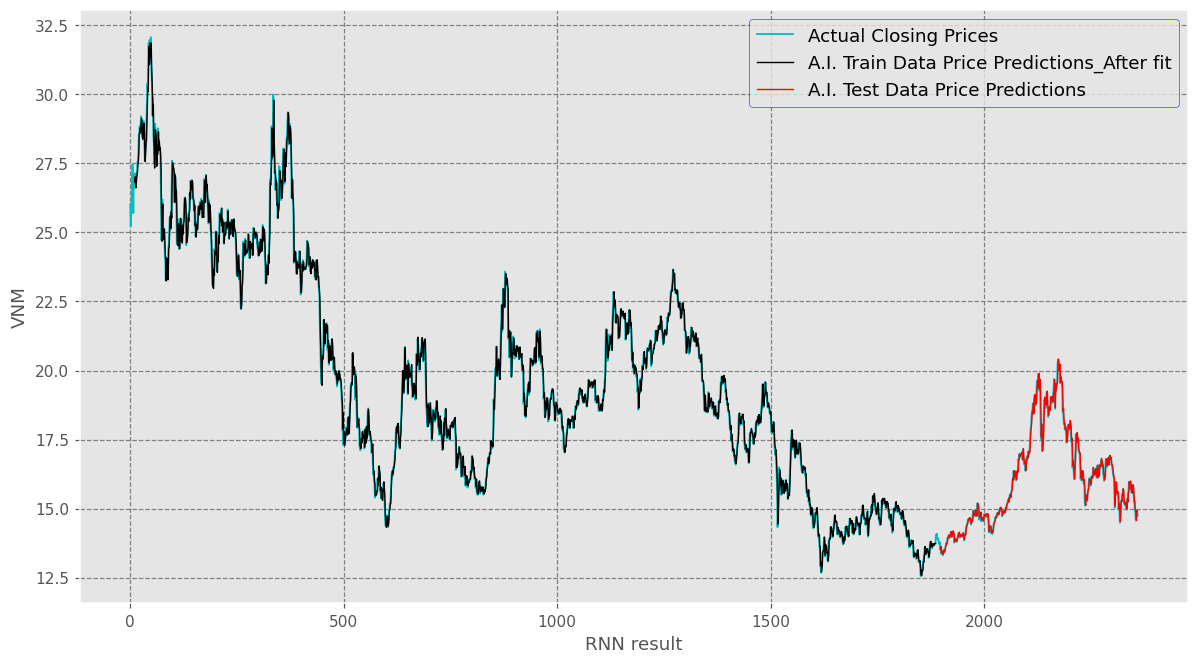

,MSE,MAE,MAPE,RMSE
RNN,0.124,0.256,1.272,0.352


In [49]:
create_plot(ds, trainPredict, testPredict, scaler, look_back, model_name, stock_name)
pd.DataFrame([[mse, mae, mape, rmse]], index=[model_name], columns=["MSE", "MAE", "MAPE", "RMSE"])